<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-and-functions" data-toc-modified-id="Data-and-functions-1">Data and functions</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2">Results</a></span><ul class="toc-item"><li><span><a href="#Medial-septal-nucleus" data-toc-modified-id="Medial-septal-nucleus-2.1">Medial septal nucleus</a></span></li><li><span><a href="#Hippocampus" data-toc-modified-id="Hippocampus-2.2">Hippocampus</a></span><ul class="toc-item"><li><span><a href="#Right-and-Left" data-toc-modified-id="Right-and-Left-2.2.1">Right and Left</a></span></li><li><span><a href="#Right-head,-body,-and-tail" data-toc-modified-id="Right-head,-body,-and-tail-2.2.2">Right head, body, and tail</a></span></li><li><span><a href="#Left-head,-body,-and-tail" data-toc-modified-id="Left-head,-body,-and-tail-2.2.3">Left head, body, and tail</a></span></li></ul></li></ul></li></ul></div>

# Data and functions

In [15]:
shhh <- suppressPackageStartupMessages # It's a library, so shhh!

shhh(suppressWarnings(library(ggplot2)))   # for plotting results
shhh(suppressWarnings(library(gridExtra))) # for adding plots together
shhh(suppressWarnings(library(grid)))      # for plot grid title formatting
shhh(suppressWarnings(library(gtools)))    # for converting pvalues to stars
shhh(suppressWarnings(library(Hmisc)))
shhh(suppressWarnings(library(plyr)))      # for ddply (aggregating results)
shhh(suppressWarnings(library(tidyr)))     # for creating long table (function gather)
shhh(suppressWarnings(library(multcomp)))  # for multiple comparison tests
shhh(suppressWarnings(library(varhandle))) # for unfactoring variables
shhh(suppressWarnings(library(Rmisc)))     # for getting summary data frame

shhh(suppressWarnings(library(tidyverse)))
shhh(suppressWarnings(library(ggpubr)))
shhh(suppressWarnings(library(rstatix)))

dataTNT <- read.csv('data/psc.csv')
dataTNT$roi = as.factor(dataTNT$roi)
dataTNT$subid = as.factor(dataTNT$subid)
head(dataTNT)

,id,stid,subid,model,rID,roi,T,NT,coverage
,<int>,<chr>,<fct>,<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>
1,1,01_Levy1,01_Levy1s_604,model_00,1,ch12,0.007320232,0.02350285,99.60630
2,1,01_Levy1,01_Levy1s_635,model_00,1,ch12,-0.038192853,-0.02542412,100.00000
3,1,01_Levy1,01_Levy1s_639,model_00,1,ch12,-0.019886187,-0.03645123,96.46643
4,1,01_Levy1,01_Levy1s_679,model_00,1,ch12,-0.041203754,-0.15598856,93.69369
5,1,01_Levy1,01_Levy1s_680,model_00,1,ch12,-0.037150442,-0.03642902,100.00000
6,1,01_Levy1,01_Levy1s_766,model_00,1,ch12,-0.062691836,-0.02872113,83.63171


In [16]:
# POOLED MEANS AND STANDARD DEVIATIONS
# Reference: https://www-ncbi-nlm-nih-gov.ezp.lib.cam.ac.uk/books/NBK56512/
# ------------------------------------
pooledMean <- function(N, M) {
  numerator <- 0
  denominator <- 0
  for (i in length(N)) {
    numerator <- numerator + (N[i] * M[i])
    denominator <- denominator + N[i]
  }
  return(numerator / denominator)
}

pooledSD <- function(N, SD) {
  numerator <- 0
  denominator <- 0
  for (i in length(N)) {
    numerator <- numerator + ((N[i] - 1) * SD[i] ^ 2)
    denominator <- denominator + N[i]
  }
  sd <- sqrt(numerator / (denominator - length(N)))
  se <- sd / sqrt(sum(N))
  ci <- se * 1.96
  return(data.frame(sd,
                    se,
                    ci))
}

In [17]:
# PLOTTING POOELD MEAN RESULTS
# dataframe 'res' should have 3 columns: Conditions, PSC, EB (error bar measures, CI or SE)
# ------------------------------------
plotMeanBars <- function(res) {
  ggplot(res, aes(x = Condition, y = PSC, fill = Condition)) +
    geom_point() +
    geom_bar(stat = "identity",
             color = "black",
             position =
               position_dodge()) +
    geom_hline(aes(yintercept = 0), color = "black") +
    geom_errorbar(aes(ymin = PSC - EB, ymax = PSC + EB),
                  width = 0) +
    scale_fill_manual(values = c('orange', '#92D050')) +
    
    scale_y_continuous(name="PSC", limits=c(-0.017, 0.007)) +
    
    theme_minimal() +
    theme(
      text = element_text(size = 14),
      plot.title = element_text(
        size = 12,
        face = "bold",
        hjust = 0.5
      ),
      plot.background = element_rect(
        color = "lightgrey",
        size = 0.4,
        linetype = "dotted"
      ),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      legend.position = "none"
    )
}

In [18]:
# PLOTTING MEANS, Group mean with SE and subject values
# ------------------------------------
plotMeans <-
  function(dataset,
           val,
           group,
           title,
           units,
           extraTxt,
           fillcolor,
           min,
           max,
           step) {
    p <- ggplot(dataset, aes(group, val, fill = group)) +
      geom_point(
        colour = "black",
        alpha = .7,
        fill = 'grey',
        size = 3,
        stroke = 0.5,
        shape = 21,
        position = position_jitter(height = 0, width = 0.05)
      ) +
      geom_boxplot(
        outlier.shape = 8,
        outlier.size = 6,
        outlier.color = "red",
        coef = 2,
        alpha = 0.5
      ) +
      stat_summary(
        fun.data = mean_se, #mean_se, #mean_cl_normal,
        geom = "pointrange",
        color = "black",
        fill = fillcolor,
        size = 1,
        stroke = 0.5,
        shape = 21,
        position = position_nudge(x = -0.1)
      ) +
      labs(x = extraTxt, y = units) + ggtitle(title) +
      coord_flip() +
      theme_minimal() +
      theme(
        text = element_text(size = 14),
        plot.title = element_text(
          size = 14,
          face = "bold",
          hjust = 0.5
        ),
        plot.background = element_rect(
          color = "lightgrey",
          size = 0.4,
          linetype = "dotted"
        ),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "none"
      )
    
    if (!missing(min) & !missing(max) & !missing(step)) {
      p + scale_y_continuous(limits = c(min, max),
                             breaks = seq(min, max, step))
    }
    
    return(p)
  }

# PLOTTING CORRELATIONS
# ------------------------------------
plotCorrelation <-
  function(dataset,
           x,
           y,
           xLabel,
           yLabel) {
    corr.grey.roi  <- rcorr(x, y)
    resTXT  <- sprintf("r = %.3f, p = %.10f",
                       corr.grey.roi$r[2],
                       corr.grey.roi$P[2])
    
    ggplot(dataset, aes(x, y)) +
      geom_smooth(
        method = lm,
        level = 0.95,
        color = "black",
        fill = "grey",
        size = 0.3
      ) +
      geom_point(
        colour = "black",
        alpha = .8,
        fill = "orange",
        size = 3,
        stroke = 0.2,
        shape = 21
      ) +
      labs(x = xLabel, y = yLabel) + ggtitle(resTXT) +
      theme_minimal() +
      theme(
        text = element_text(size = 14),
        plot.title = element_text(
          hjust = 0.5,
          size = 14,
          face = "bold"
        ),
        plot.background = element_rect(
          colour = "lightgrey",
          size = 0.4,
          linetype = "dotted"
        ),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()
      )
  }

# PLOTTING DENSITIES
# ------------------------------------
plotDensities <- function(dataset, val, group, measure) {
  ggplot(dataset, aes(x = val, fill = group)) +
    geom_density(alpha = 0.7,
                 size = 1,
                 color = "white") +
    ylab('density') + xlab(measure) +
    scale_fill_manual(values = c('orange', '#92D050')) +
    theme_minimal() +
    theme(
      legend.position = "top",
      legend.title = element_blank(),
      text = element_text(size = 14),
      plot.title = element_text(
        size = 12,
        face = "bold",
        hjust = 0.5
      ),
      plot.background = element_rect(
        color = "lightgrey",
        size = 0.4,
        linetype = "dotted"
      ),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank()
    )
}

# ------------------------------------

In [19]:
perROIperDSmeans <- function(data, ns)
  for (i in ns) {
    data <- subset(dataTNT, dataTNT$rID == i)
    
    # Plot mean T-NT difference per dataset
    pMeans <- plotMeans(data,
                        data$T - data$NT,
                        data$stid,
                        "T-NT",
                        "%",
                        data$roi,
                        "red") +
      geom_hline(aes(yintercept = 0), size = 0.1)
      print(pMeans)
           
    print('________________________________________________________________________________', quote = FALSE)
    print(' ', quote = FALSE)
    print(sprintf('%s %s', 'ROI: ', unique(data$roi)), quote = FALSE)
    print('________________________________________________________________________________', quote = FALSE)
    print(' ', quote = FALSE)
    
    print('================================================', quote = FALSE)
    print('Mixed ANOVA (Condition x Dataset)', quote = FALSE)
    print('================================================', quote = FALSE)
    
    # Gather the columns T and NT into long format.
    # Convert id and time into factor variables
    datalong <- data %>%
      gather(key = "condition", value = "PSC", T, NT) %>%
      convert_as_factor(condition)
    
    # Two-way mixed ANOVA test
    res.aov <- anova_test(
      data = datalong,
      dv = PSC,
      wid = subid,
      between = stid,
      within = condition,
      effect.size = "ges"
    )
    print(get_anova_table(res.aov))
    
    print(' ', quote = FALSE)
    print('================================================', quote = FALSE)
    print('Simple main effects of Condition', quote = FALSE)
    print('================================================', quote = FALSE)
    # Effect of Condition for each dataset
    one.way2 <- datalong %>%
      group_by(stid) %>%
      anova_test(
        dv = PSC,
        wid = subid,
        within = condition,
        effect.size = "ges"
      ) %>%
      get_anova_table()
    
    print(one.way2)
    
    print(' ', quote = FALSE)
    print('================================================', quote = FALSE)
    print('Paired t-test for all data together', quote = FALSE)
    print('================================================', quote = FALSE)
    
    paired <- datalong %>%
      pairwise_t_test(PSC ~ condition,
                      paired = TRUE,
                      p.adjust.method = "none")
    
    res.txt.paired <- sprintf('t(%d) = %.2f, p = %.10f, d = %.3f',
                              paired[["df"]],
                              paired[["statistic"]],
                              paired[["p"]],
                              abs(paired[["statistic"]] / sqrt(paired[["df"]] + 1)))
    
    print(res.txt.paired, quote = FALSE)
    
    print(' ', quote = FALSE)
    print('================================================', quote = FALSE)
    print('Pooled Mean, Standard Error, 95% CI', quote = FALSE)
    print('================================================', quote = FALSE)
    
    T  <-
      aggregate(
        data$T,
        list(data$stid),
        FUN = function(x)
          c(
            n = length(x),
            mean = mean(x),
            sd = sd(x)
          )
      )
    NT <-
      aggregate(
        data$NT,
        list(data$stid),
        FUN = function(x)
          c(
            n = length(x),
            mean = mean(x),
            sd = sd(x)
          )
      )
    
    pM_T <- pooledMean(T$x[, 'n'], T$x[, 'mean'])
    pSD_T <- pooledSD(T$x[, 'n'], T$x[, 'sd'])
    
    pM_NT <- pooledMean(NT$x[, 'n'], NT$x[, 'mean'])
    pSD_NT <- pooledSD(NT$x[, 'n'], NT$x[, 'sd'])
    
    print(
      sprintf(
        'T: M = %.3f, SE = %.3f, 95%%CI = [%.3f, %.3f]',
        pM_T,
        pSD_T$se,
        pM_T - pSD_T$ci,
        pM_T + pSD_T$ci
      ),
      quote = FALSE
    )
    print(
      sprintf(
        'N: M = %.3f, SE = %.3f, 95%%CI = [%.3f, %.3f]',
        pM_NT,
        pSD_NT$se,
        pM_NT - pSD_NT$ci,
        pM_NT + pSD_NT$ci
      ),
      quote = FALSE
    )
    
    ## Put the pooled mean resuls in a dataframe
    Condition <- c('T', 'NT')
    PSC       <- c(pM_T, pM_NT)
    EB        <- c(pSD_T$se, pSD_NT$se) #c(pSD_T$ci, pSD_NT$ci)
    
    res <- data.frame(Condition, PSC, EB)
    res$conditions <- as.factor(res$Condition)
      
    # ===========================================================
    # PLOTS
    # ===========================================================  
    
    # the pooled means
    pPooledMeans <- plotMeanBars(res)
    #ggsave(file="pPooledMeans.svg", pPooledMeans, width=2, height=3)
        
    # the density plot
    pDens <- plotDensities(datalong, datalong$PSC, datalong$condition, "%")  
    
    # all together
    # for some reason for multiple datasets it only plots properly if pMeans 
    # is printed at the top and also added here in the grob
    g <- arrangeGrob(pMeans, pPooledMeans, pDens, 
                     layout_matrix = rbind(c(1,1,1,1,1,1),c(1,1,1,1,1,1),c(2,3,3,3,3,3)))
    grid.draw(g)
      
  }

# Results

## Medial septal nucleus

[1] ________________________________________________________________________________
[1]  
[1] ROI:  ch12
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd      F        p p<.05   ges
1           stid   9 320  2.710 5.00e-03     * 0.055
2      condition   1 320 44.435 1.15e-10     * 0.031
3 stid:condition   9 320  1.976 4.10e-02     * 0.013
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd     F        p `p<.05`   ges
 * <chr>           <chr>     <dbl> <dbl> <dbl>    <dbl> <chr>   <dbl>
 1 01_Levy1        condition     1    17  4.49 0.049    "*"     0.083
 2 02_Levy2        condition     1    1

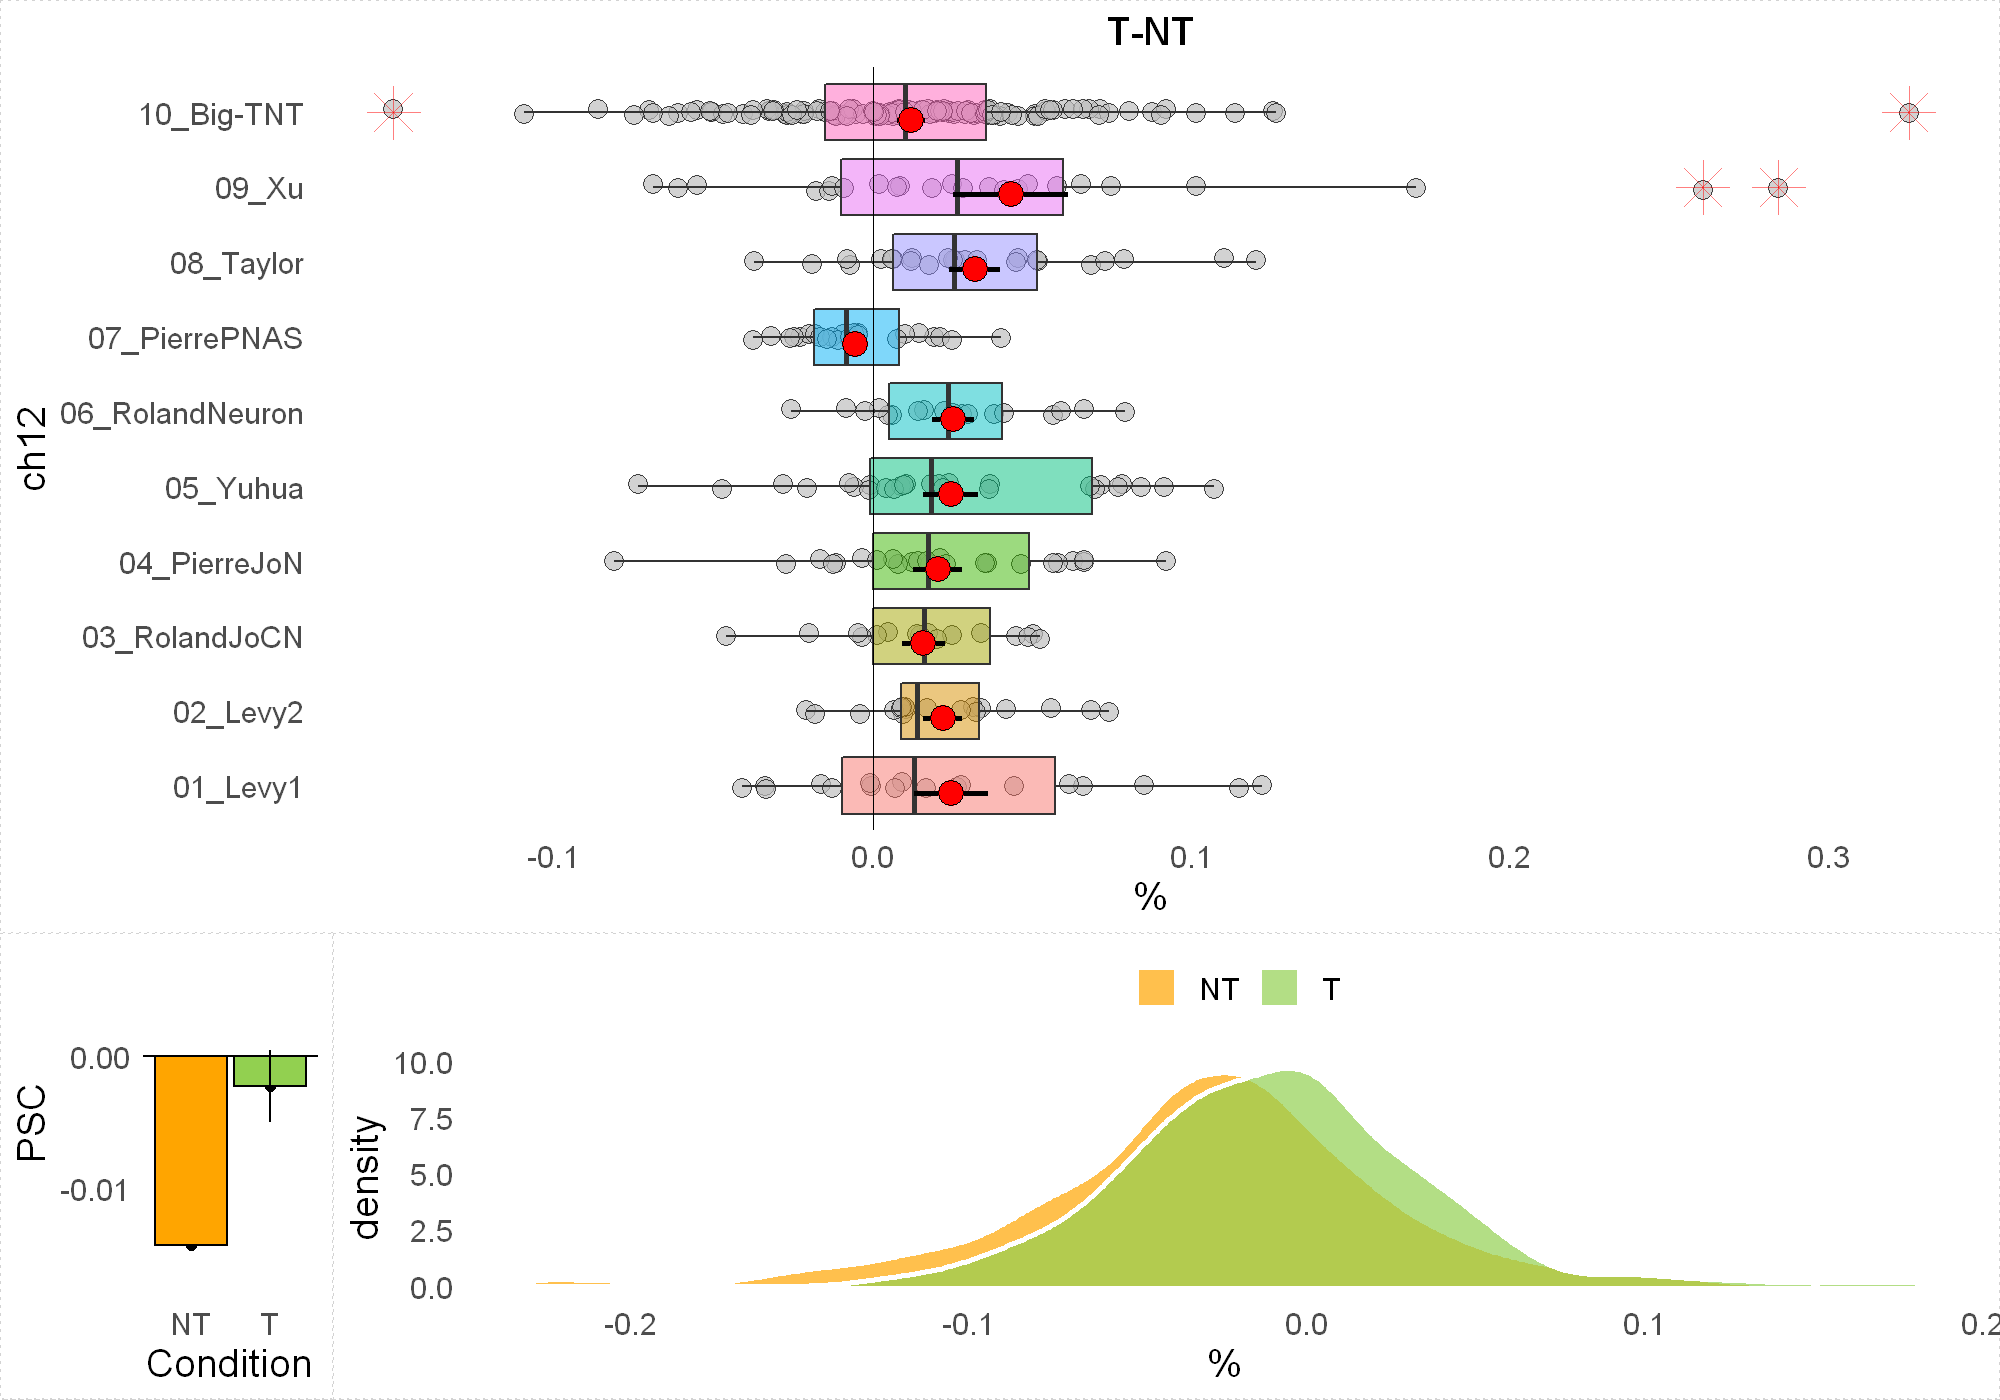

In [20]:
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)
perROIperDSmeans(dataTNT, 1)

## Hippocampus 

### Right and Left

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_Right
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd      F        p p<.05   ges
1           stid   9 320  2.454 1.00e-02     * 0.051
2      condition   1 320 31.256 4.85e-08     * 0.022
3 stid:condition   9 320  1.484 1.52e-01       0.009
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd      F           p `p<.05`      ges
 * <chr>           <chr>     <dbl> <dbl>  <dbl>       <dbl> <chr>      <dbl>
 1 01_Levy1        condition     1    17  6.80  0.018       "*"     0.078   
 2 02_Levy2   

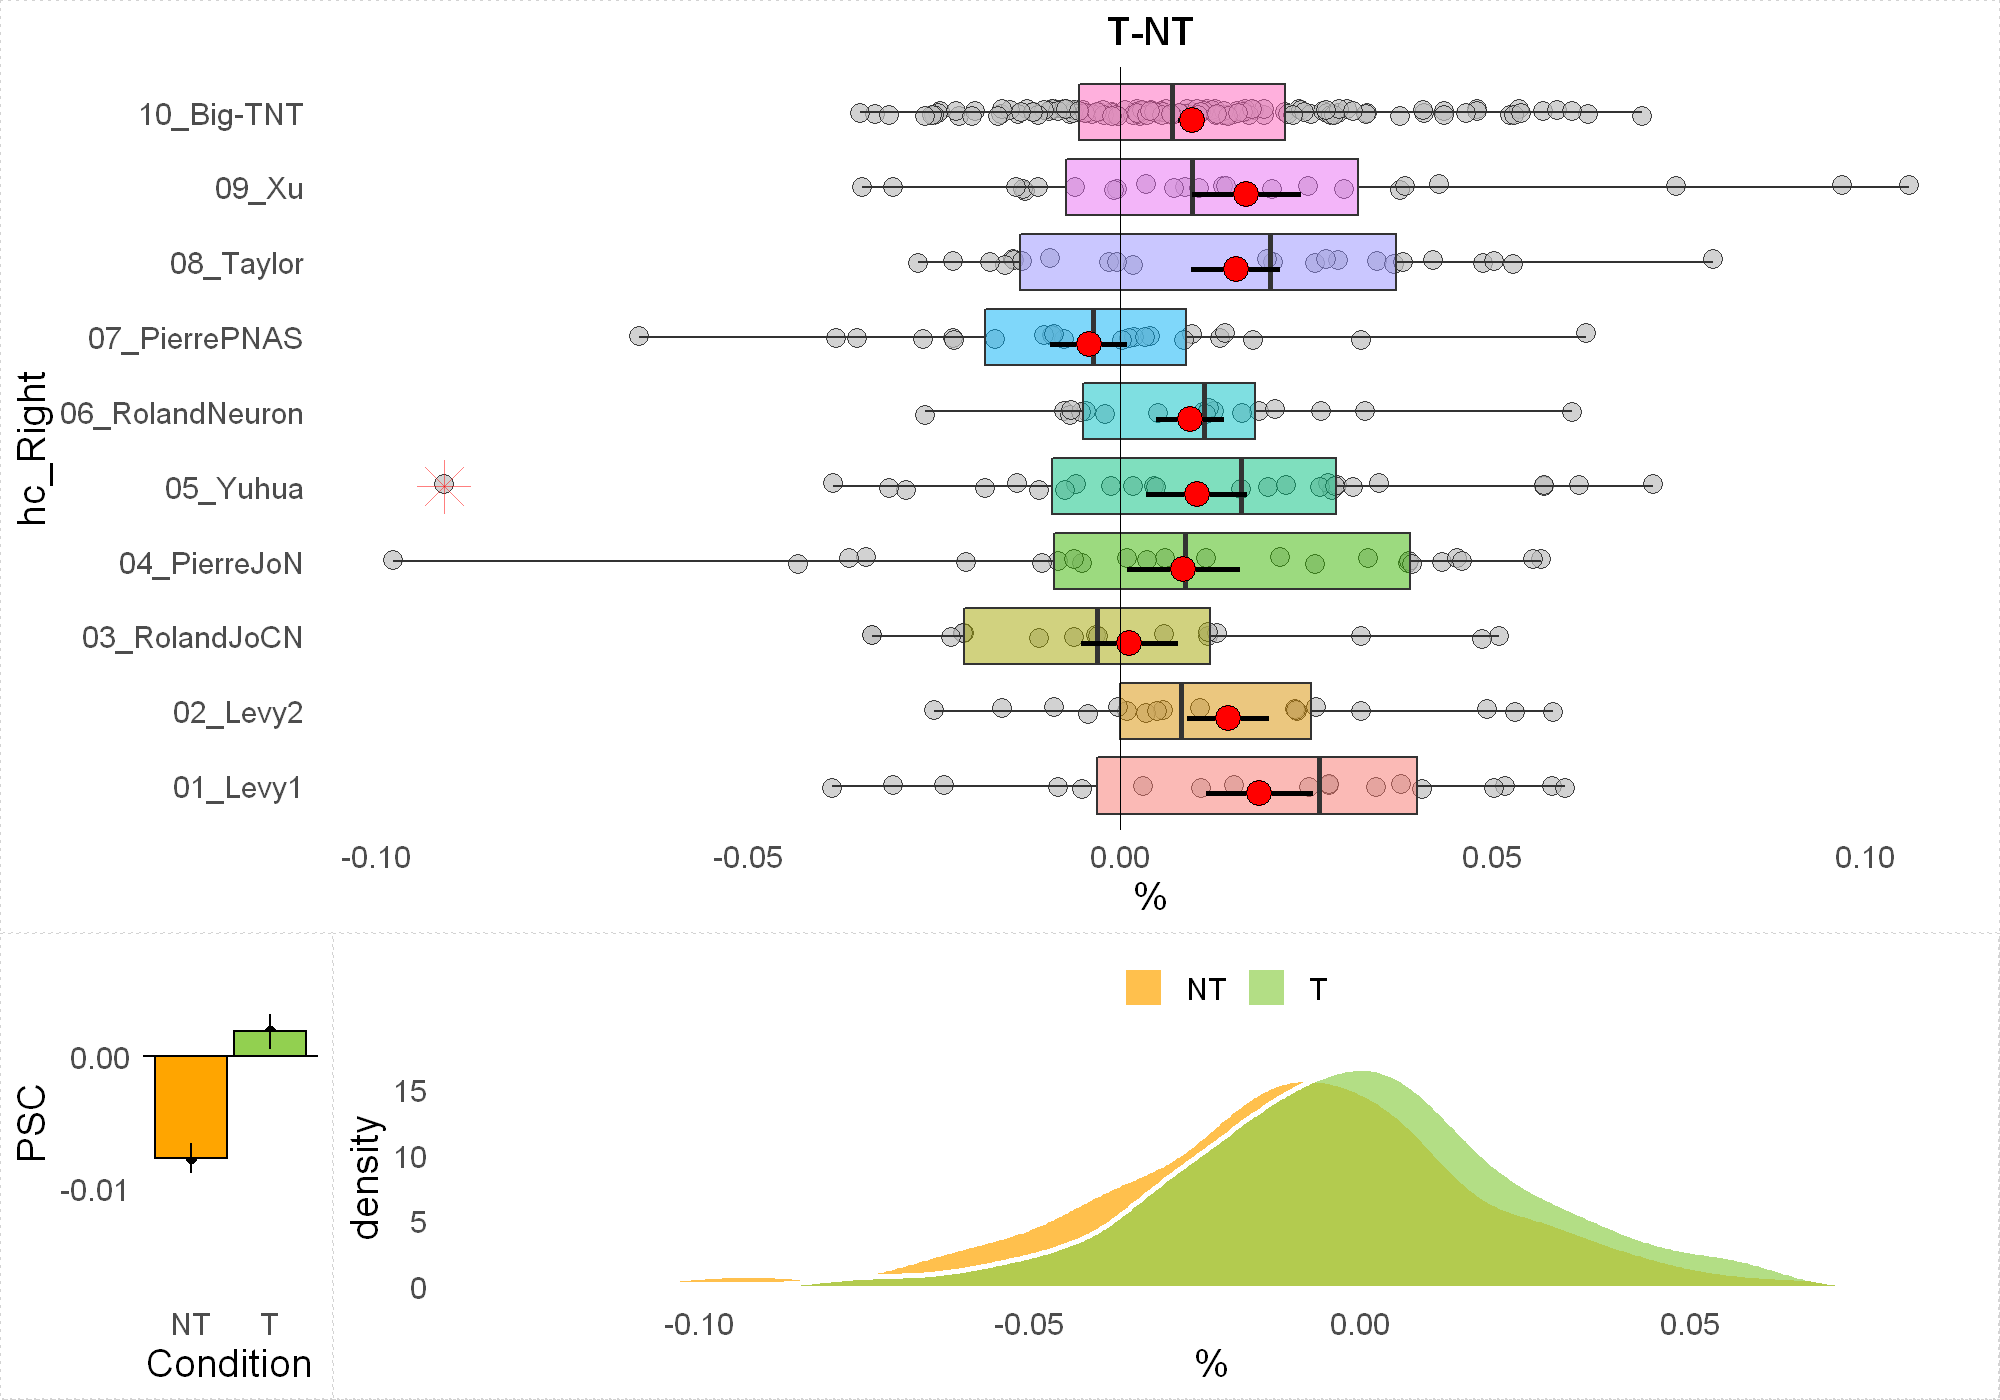

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_Left
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd      F       p p<.05   ges
1           stid   9 320  2.311 1.6e-02     * 0.047
2      condition   1 320 17.453 3.8e-05     * 0.013
3 stid:condition   9 320  1.982 4.1e-02     * 0.014
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd     F        p `p<.05`   ges
 * <chr>           <chr>     <dbl> <dbl> <dbl>    <dbl> <chr>   <dbl>
 1 01_Levy1        condition     1    17  4.88 0.041    "*"     0.065
 2 02_Levy2        condition     1    17

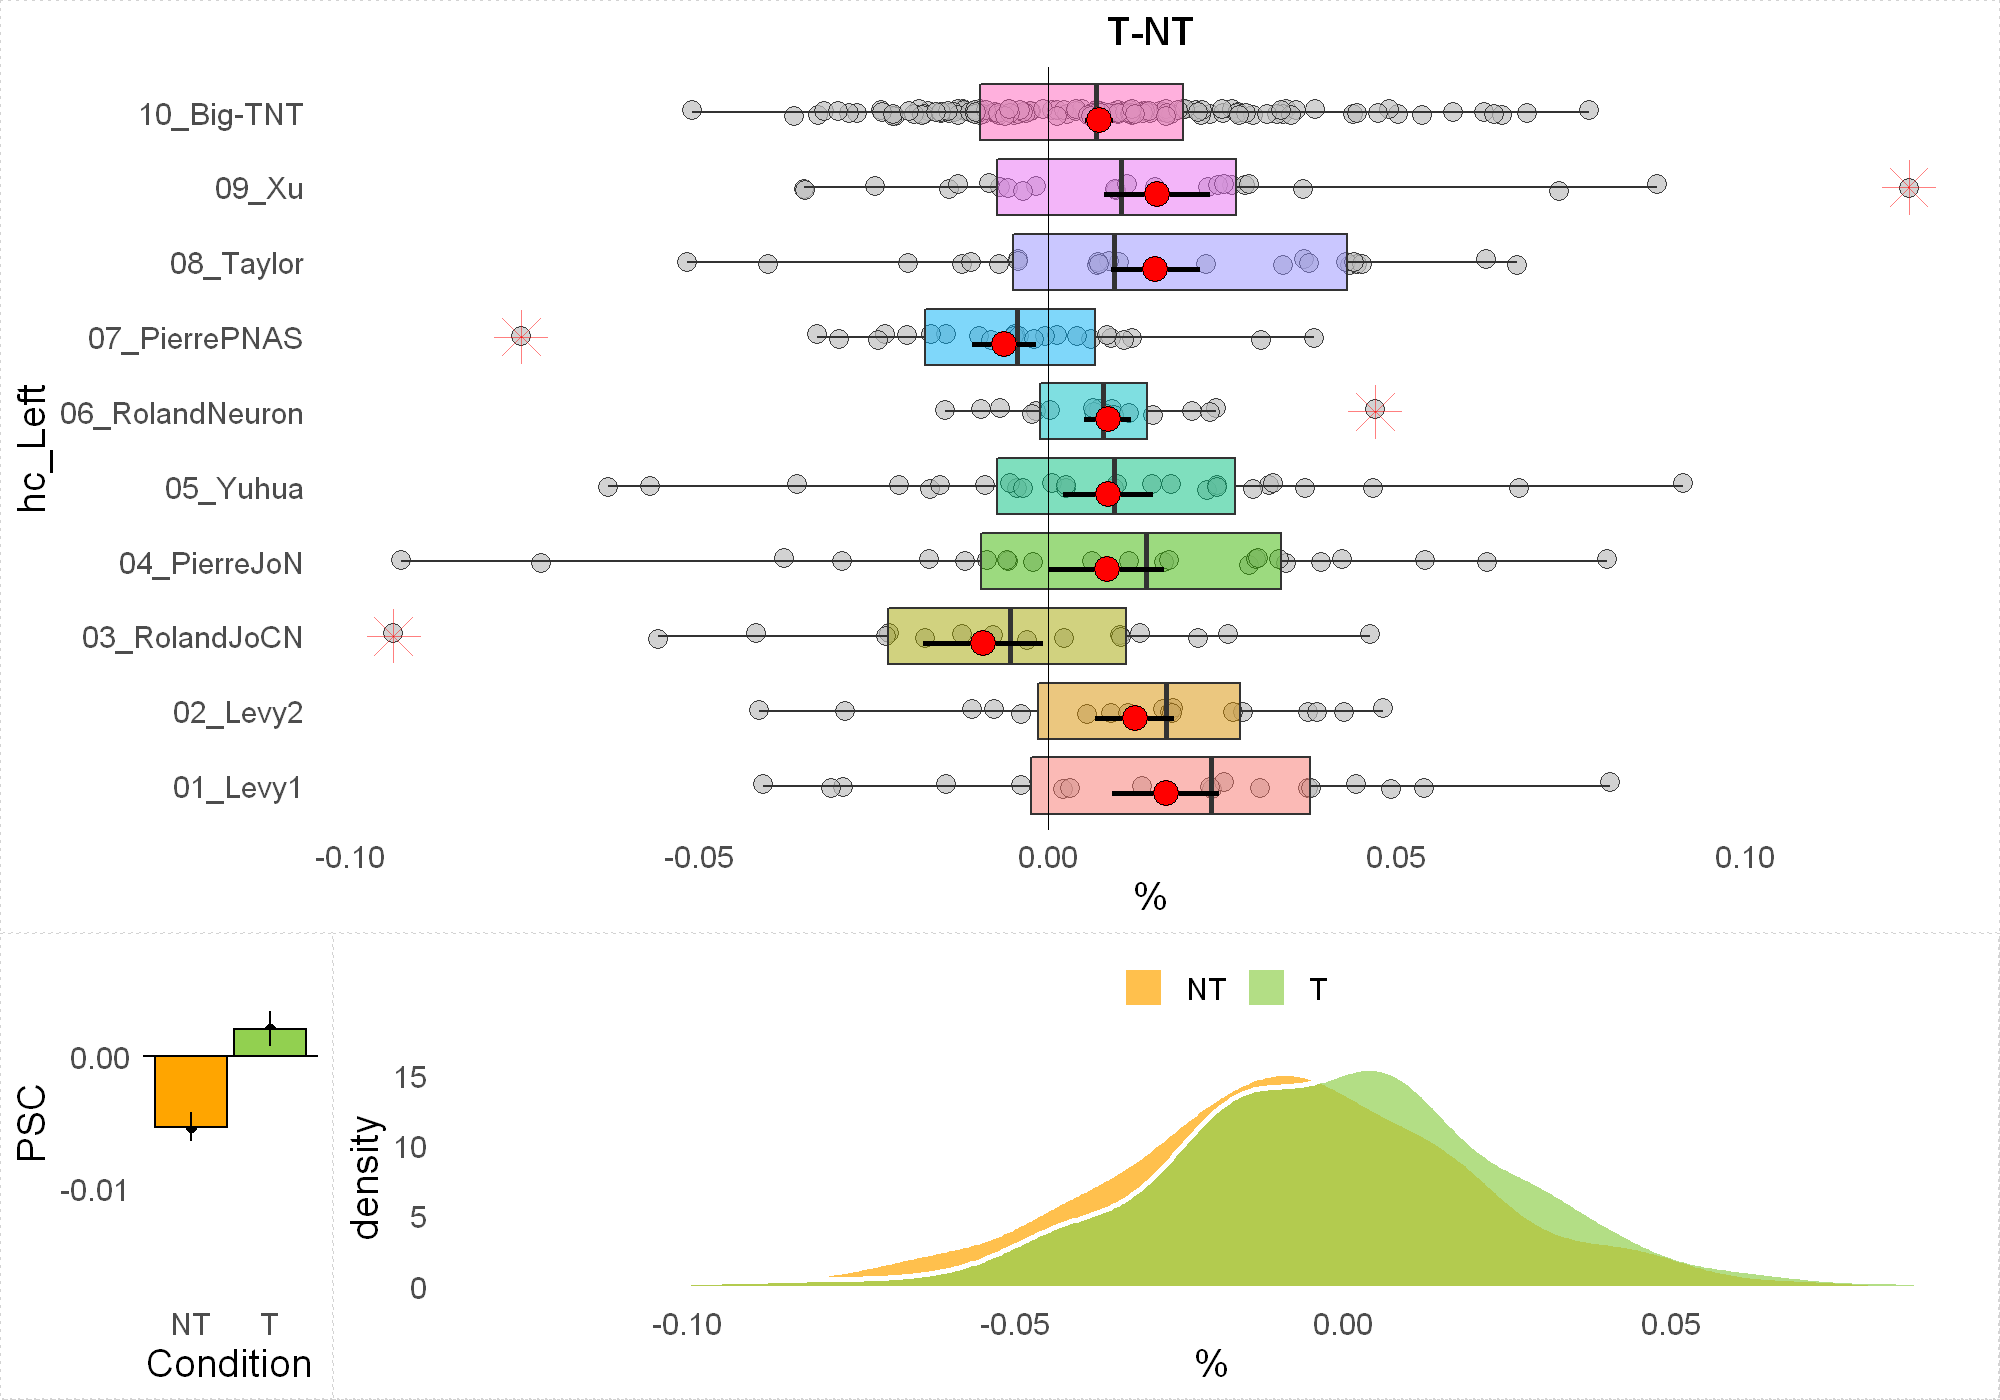

In [21]:
perROIperDSmeans(dataTNT, 2:3)

### Right head, body, and tail

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_rTail
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd        F     p p<.05      ges
1           stid   9 320 1.336000 0.217       3.10e-02
2      condition   1 320 0.000156 0.990       7.89e-08
3 stid:condition   9 320 2.139000 0.026     * 1.00e-02
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd      F        p `p<.05`      ges
 * <chr>           <chr>     <dbl> <dbl>  <dbl>    <dbl> <chr>      <dbl>
 1 01_Levy1        condition     1    17  1.74  0.204    ""      0.023   
 2 02_Levy2    

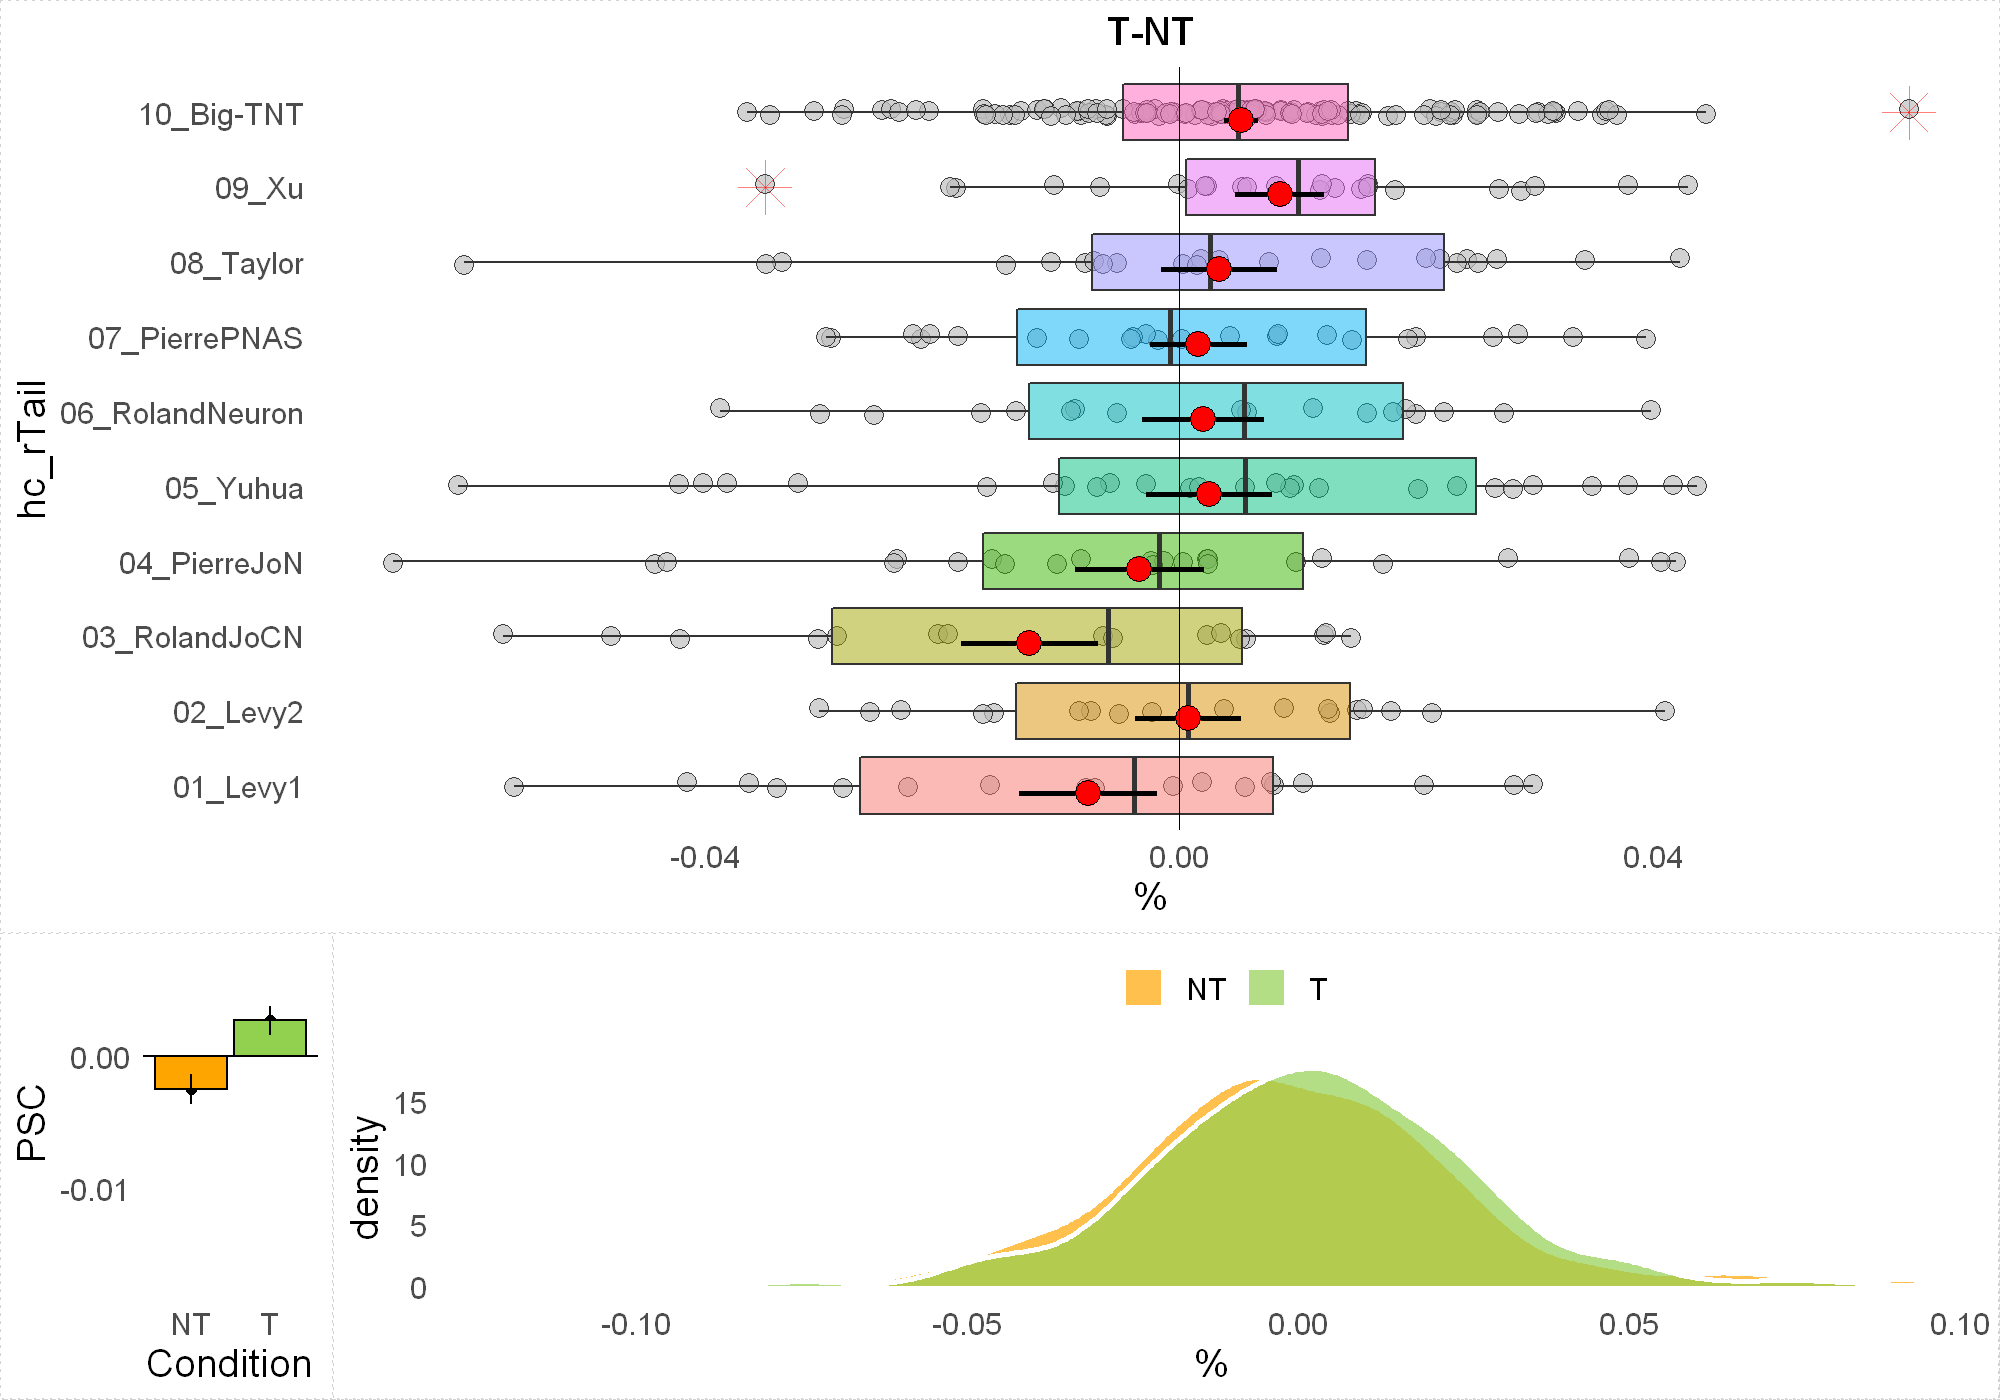

In [22]:
perROIperDSmeans(dataTNT, 6)

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_rHead
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd      F        p p<.05   ges
1           stid   9 320  3.627 2.51e-04     * 0.072
2      condition   1 320 35.945 5.47e-09     * 0.026
3 stid:condition   9 320  1.884 5.40e-02       0.012
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd      F         p `p<.05`   ges
 * <chr>           <chr>     <dbl> <dbl>  <dbl>     <dbl> <chr>   <dbl>
 1 01_Levy1        condition     1    17  9.95  0.006     "*"     0.111
 2 02_Levy2        condition 

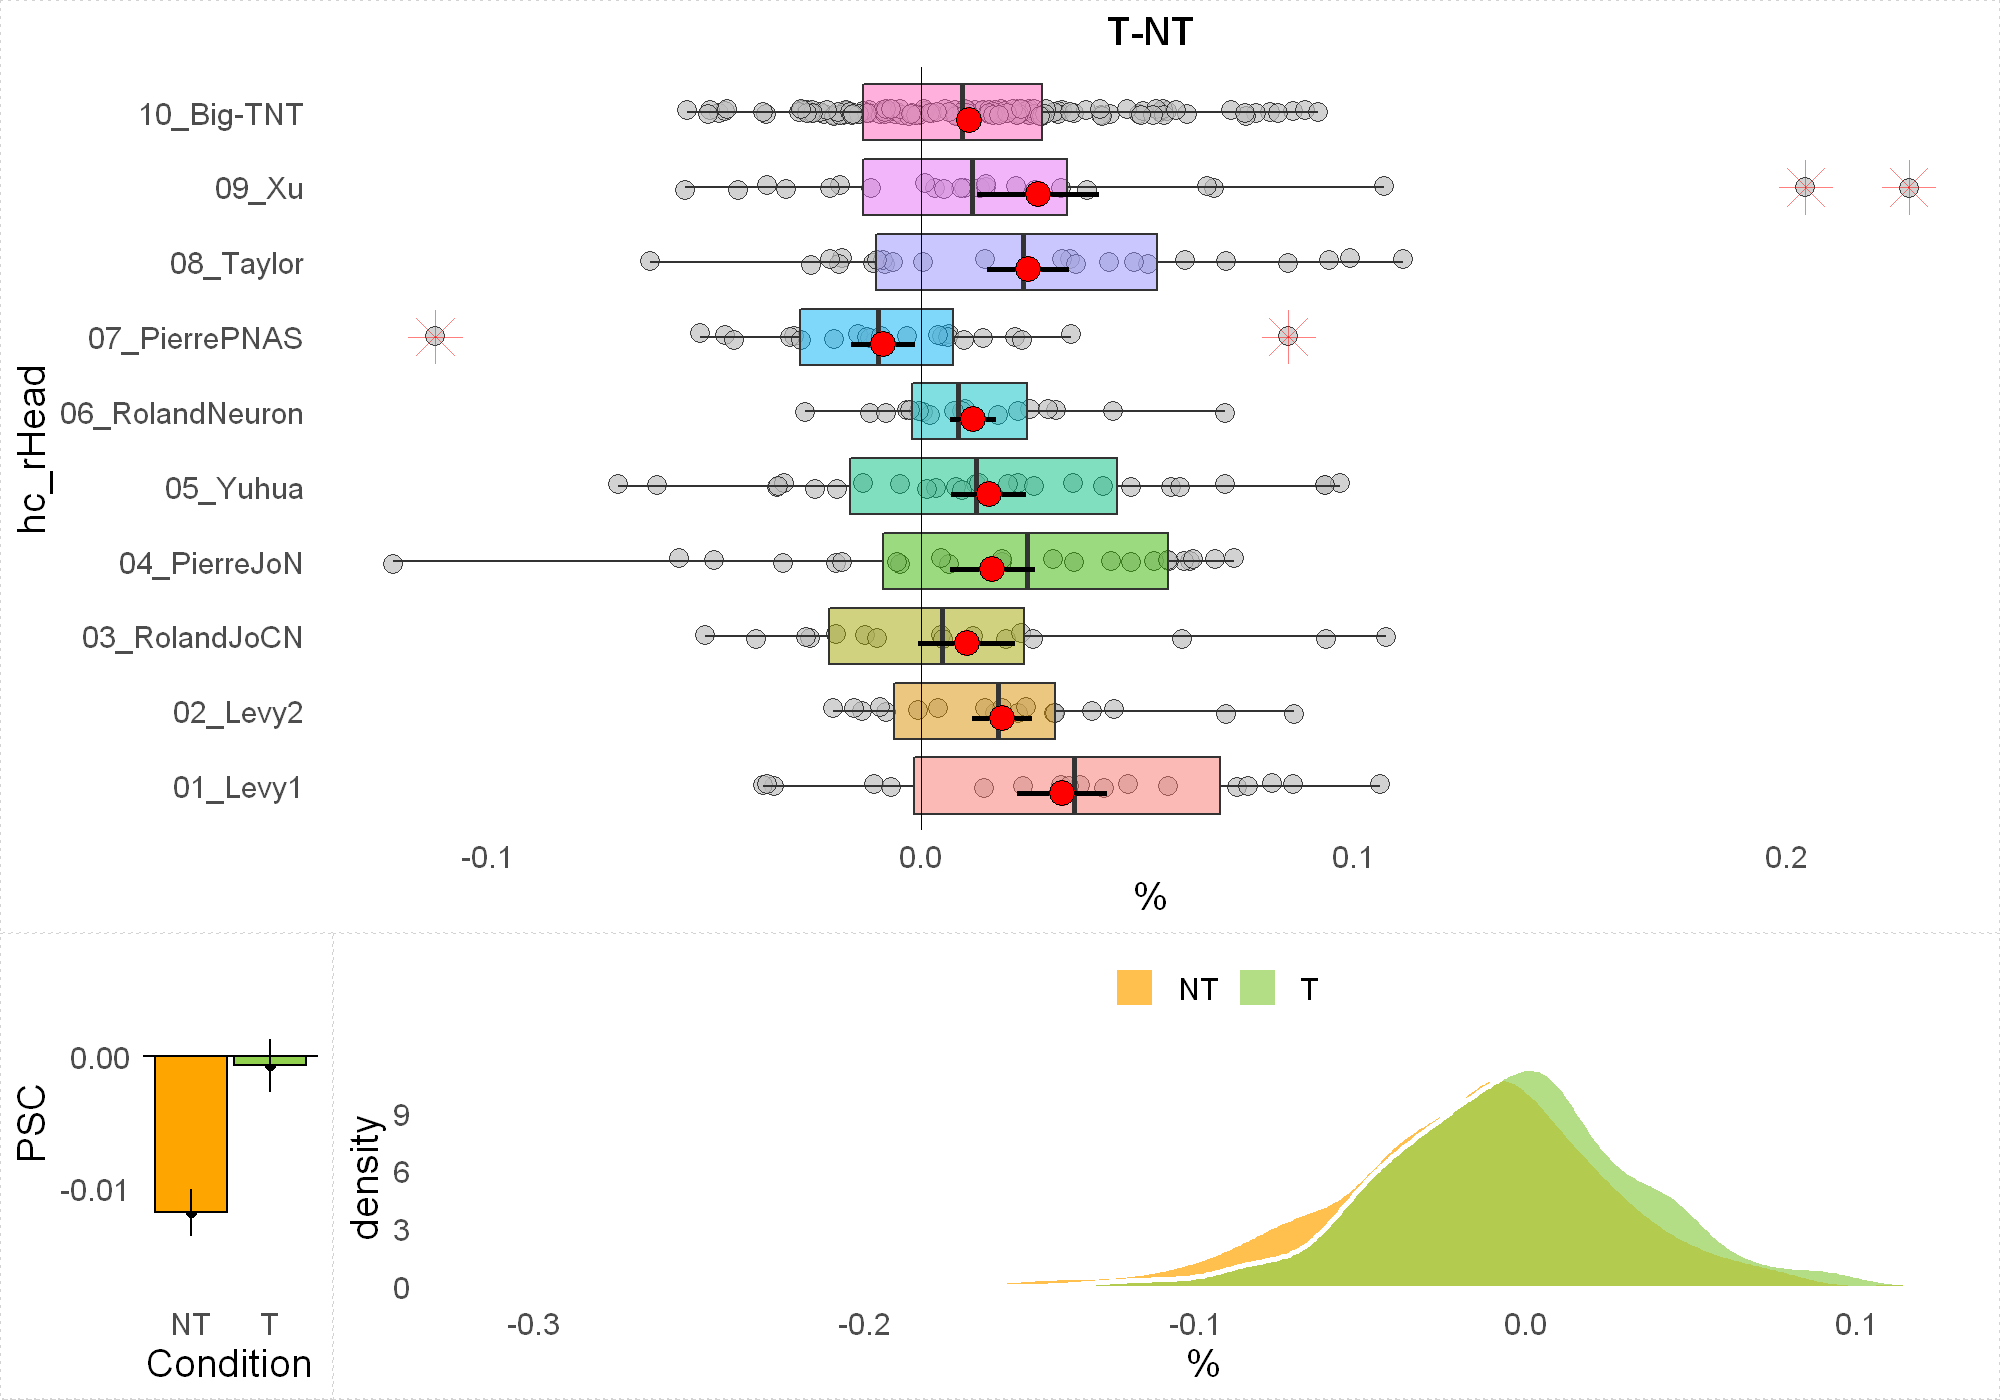

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_rBody
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd      F       p p<.05   ges
1           stid   9 320  2.838 3.0e-03     * 0.057
2      condition   1 320 24.991 9.5e-07     * 0.019
3 stid:condition   9 320  1.975 4.2e-02     * 0.013
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd      F             p `p<.05`   ges
 * <chr>           <chr>     <dbl> <dbl>  <dbl>         <dbl> <chr>   <dbl>
 1 01_Levy1        condition     1    17  7.00  0.017         "*"     0.092
 2 02_Levy2        co

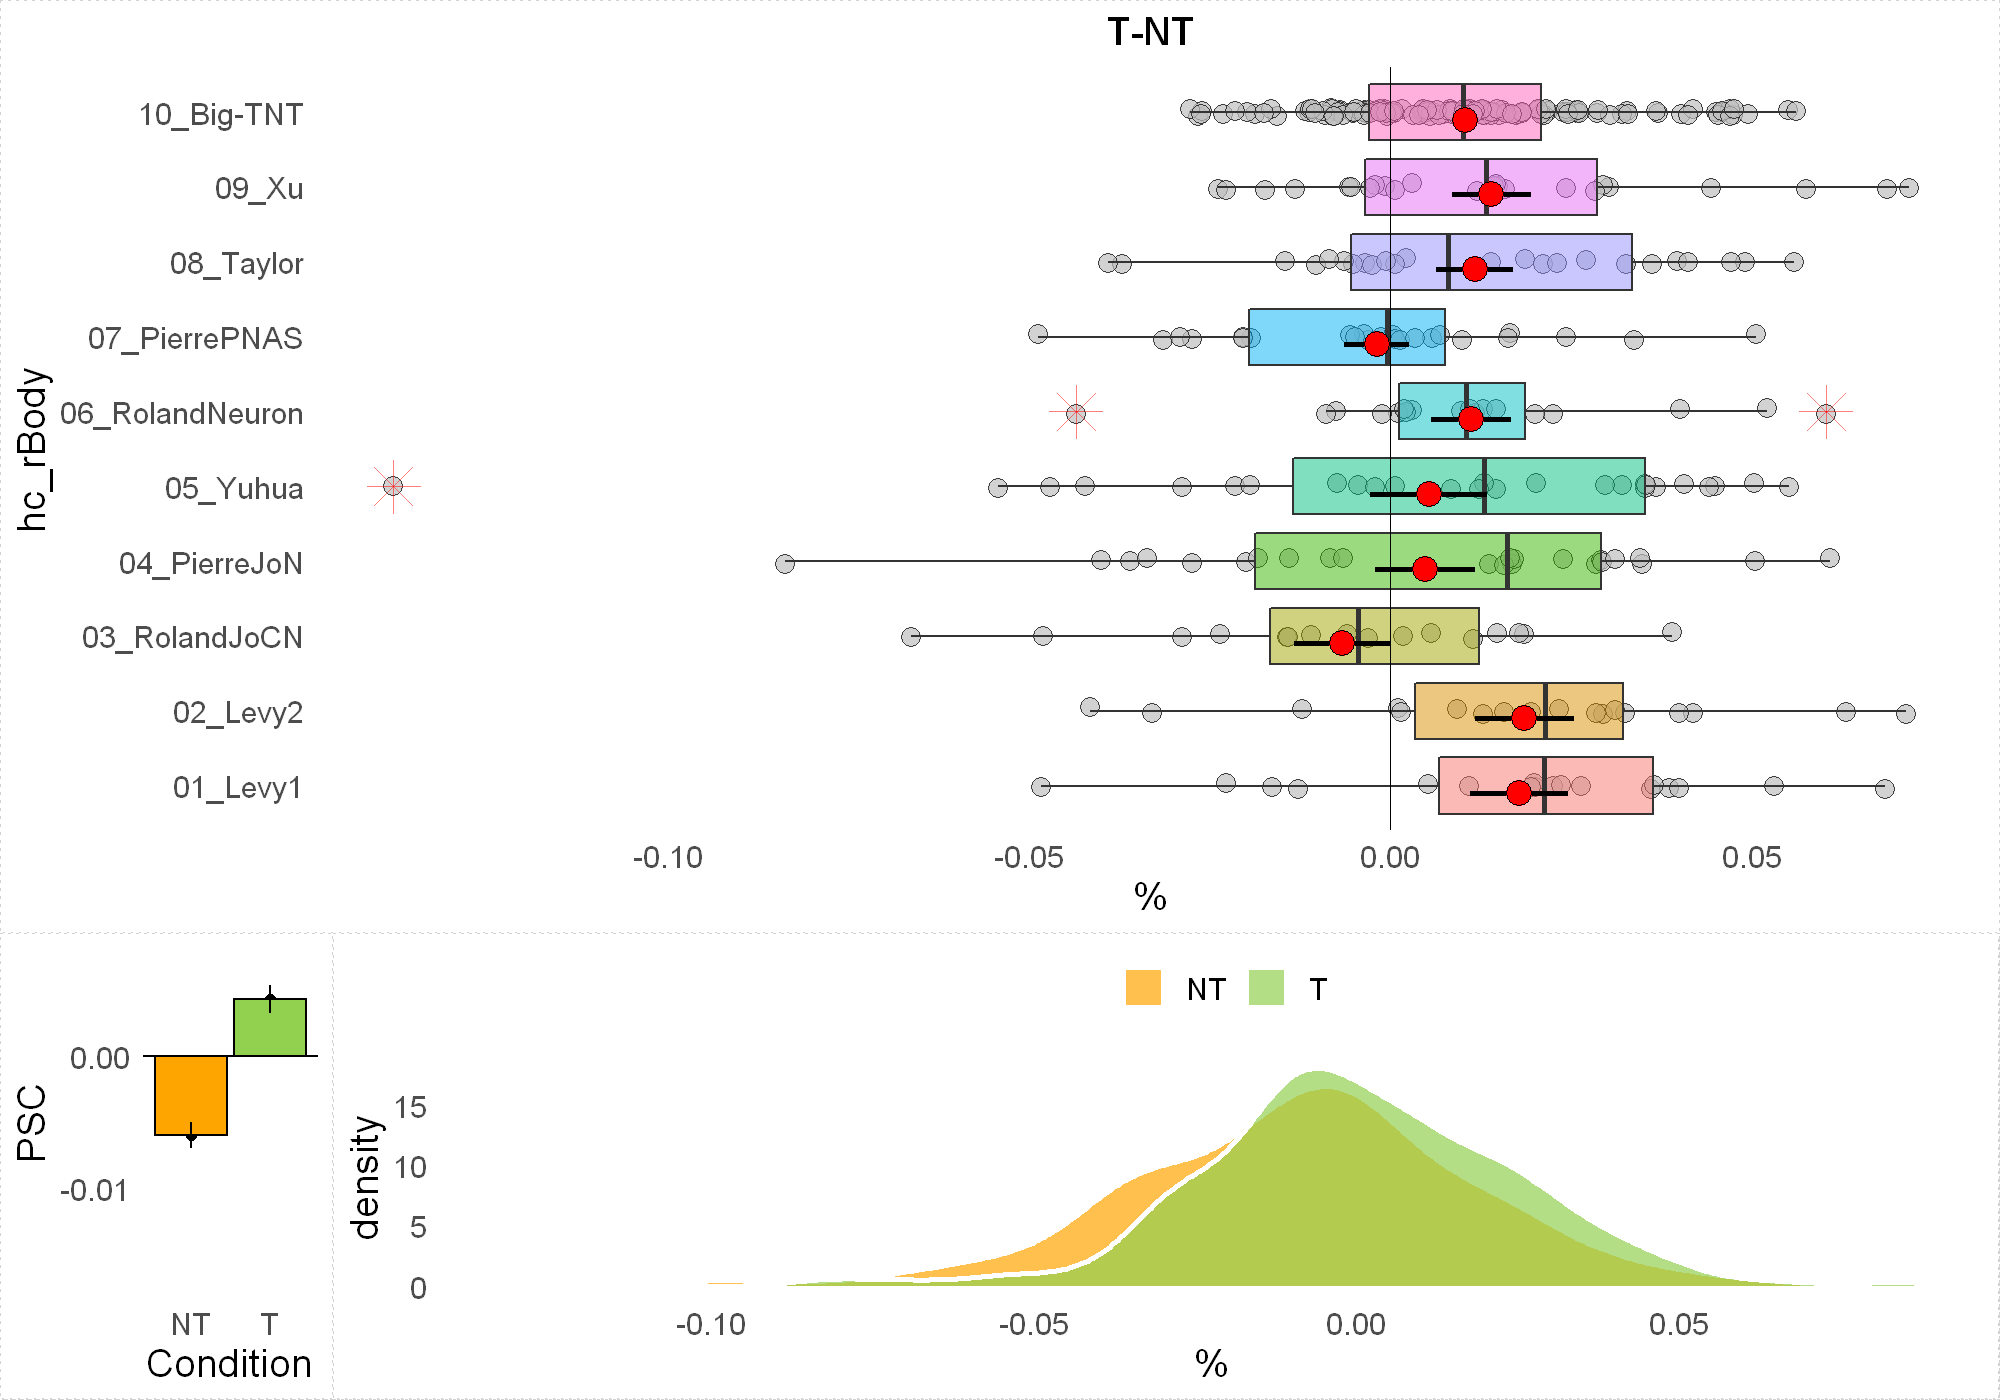

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_rTail
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd        F     p p<.05      ges
1           stid   9 320 1.336000 0.217       3.10e-02
2      condition   1 320 0.000156 0.990       7.89e-08
3 stid:condition   9 320 2.139000 0.026     * 1.00e-02
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd      F        p `p<.05`      ges
 * <chr>           <chr>     <dbl> <dbl>  <dbl>    <dbl> <chr>      <dbl>
 1 01_Levy1        condition     1    17  1.74  0.204    ""      0.023   
 2 02_Levy2    

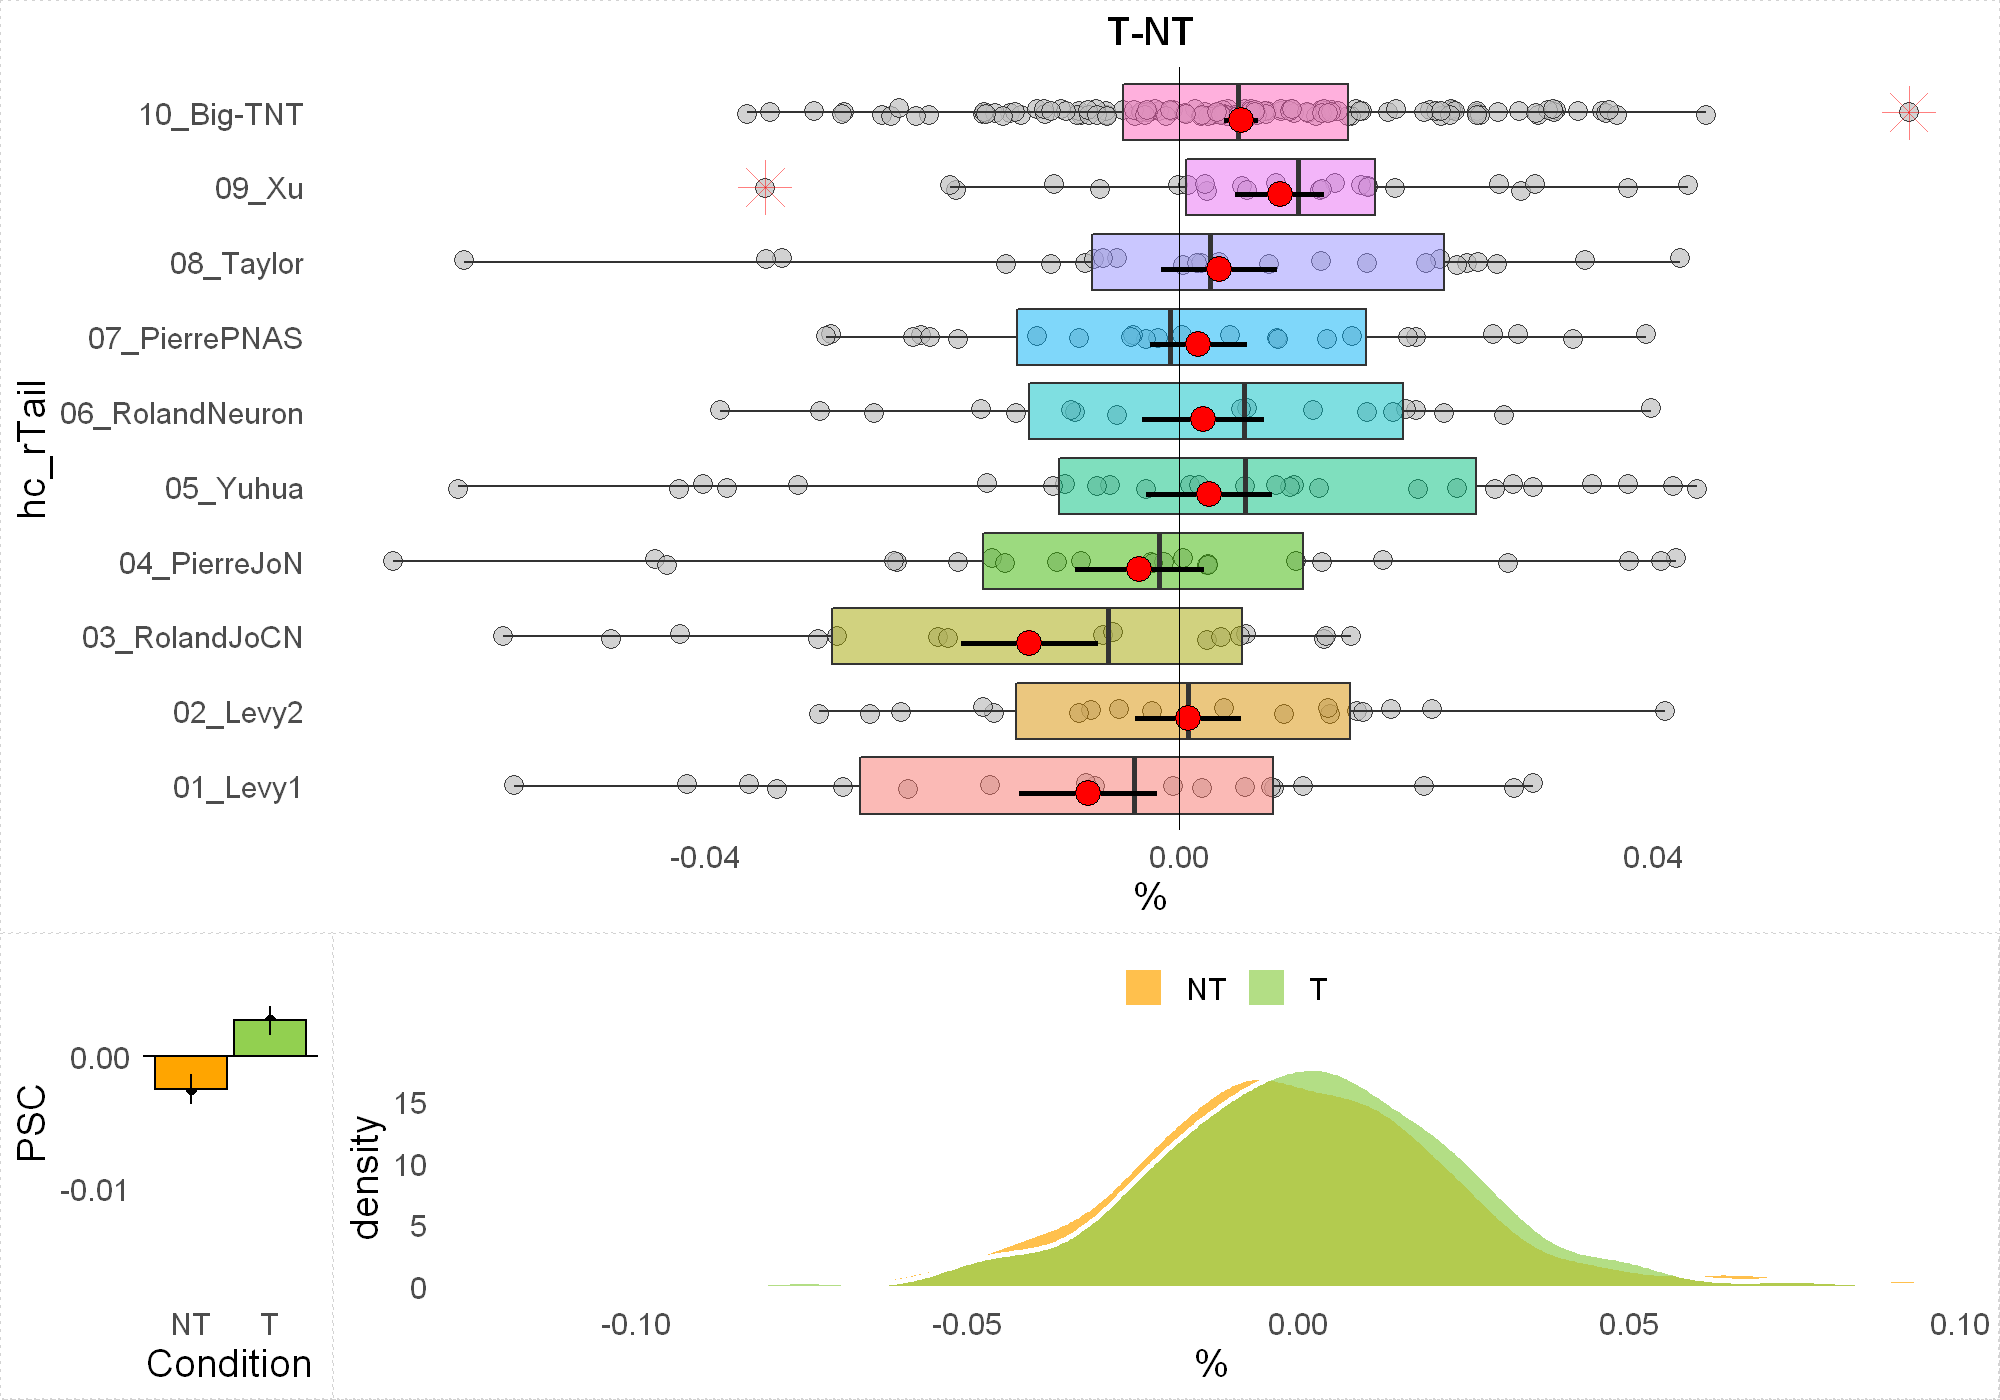

In [23]:
perROIperDSmeans(dataTNT, 4:6)

### Left head, body, and tail

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_lHead
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd      F       p p<.05   ges
1           stid   9 320  3.827 1.3e-04     * 0.073
2      condition   1 320 28.473 1.8e-07     * 0.024
3 stid:condition   9 320  2.603 7.0e-03     * 0.020
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd      F     p `p<.05`   ges
 * <chr>           <chr>     <dbl> <dbl>  <dbl> <dbl> <chr>   <dbl>
 1 01_Levy1        condition     1    17 10.3   0.005 "*"     0.101
 2 02_Levy2        condition     1    17  6.3

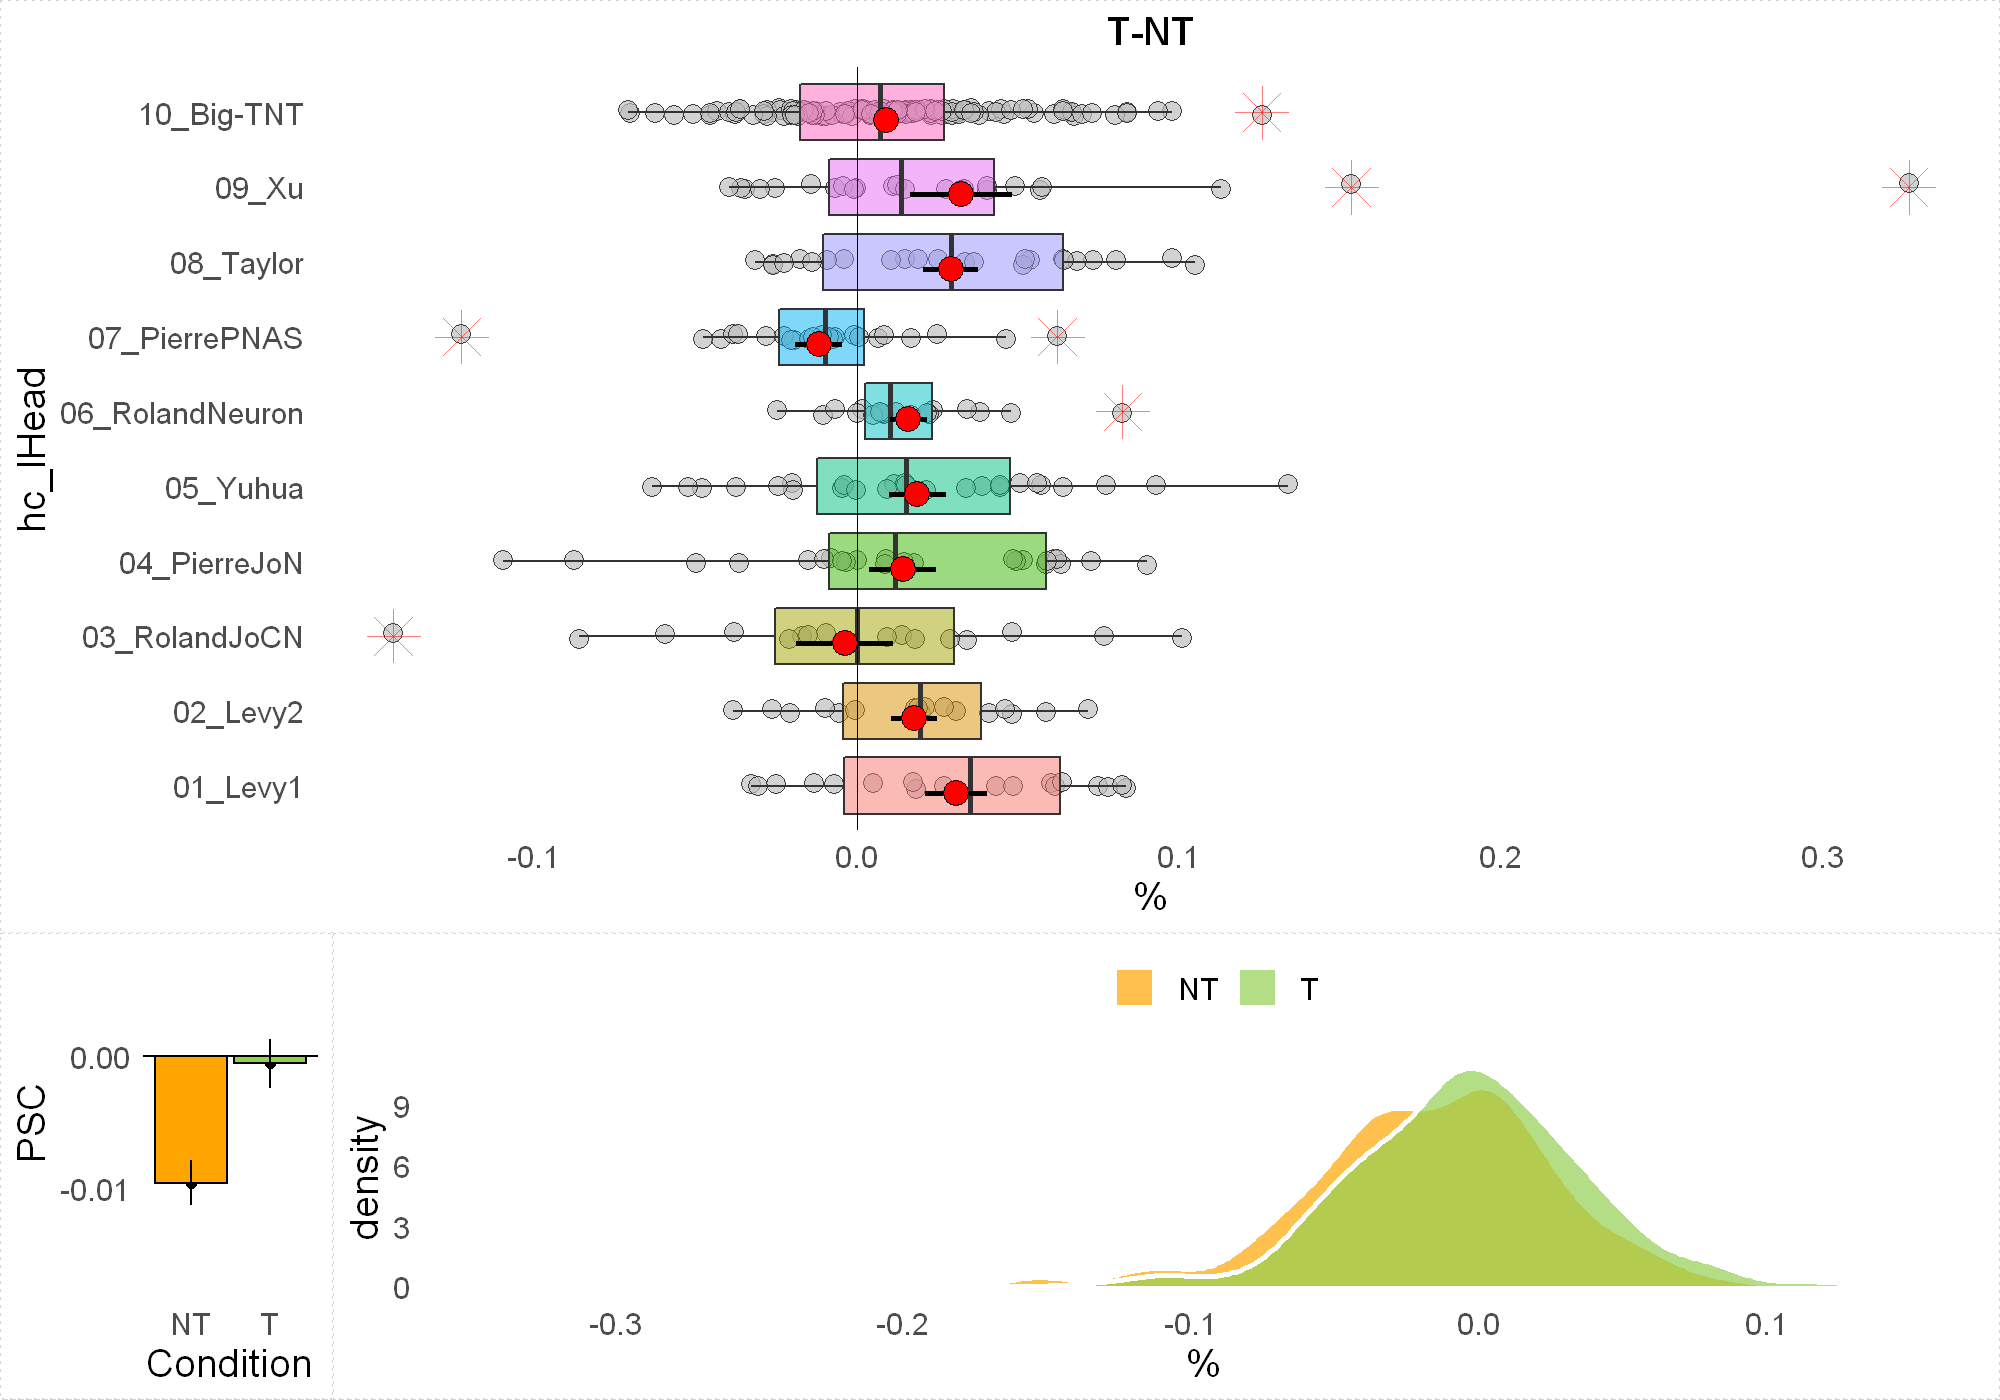

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_lBody
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd     F     p p<.05   ges
1           stid   9 320 2.565 0.007     * 0.052
2      condition   1 320 9.151 0.003     * 0.007
3 stid:condition   9 320 2.175 0.024     * 0.014
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd      F         p `p<.05`   ges
 * <chr>           <chr>     <dbl> <dbl>  <dbl>     <dbl> <chr>   <dbl>
 1 01_Levy1        condition     1    17  4.56  0.048     "*"     0.068
 2 02_Levy2        condition     1    17  7.4

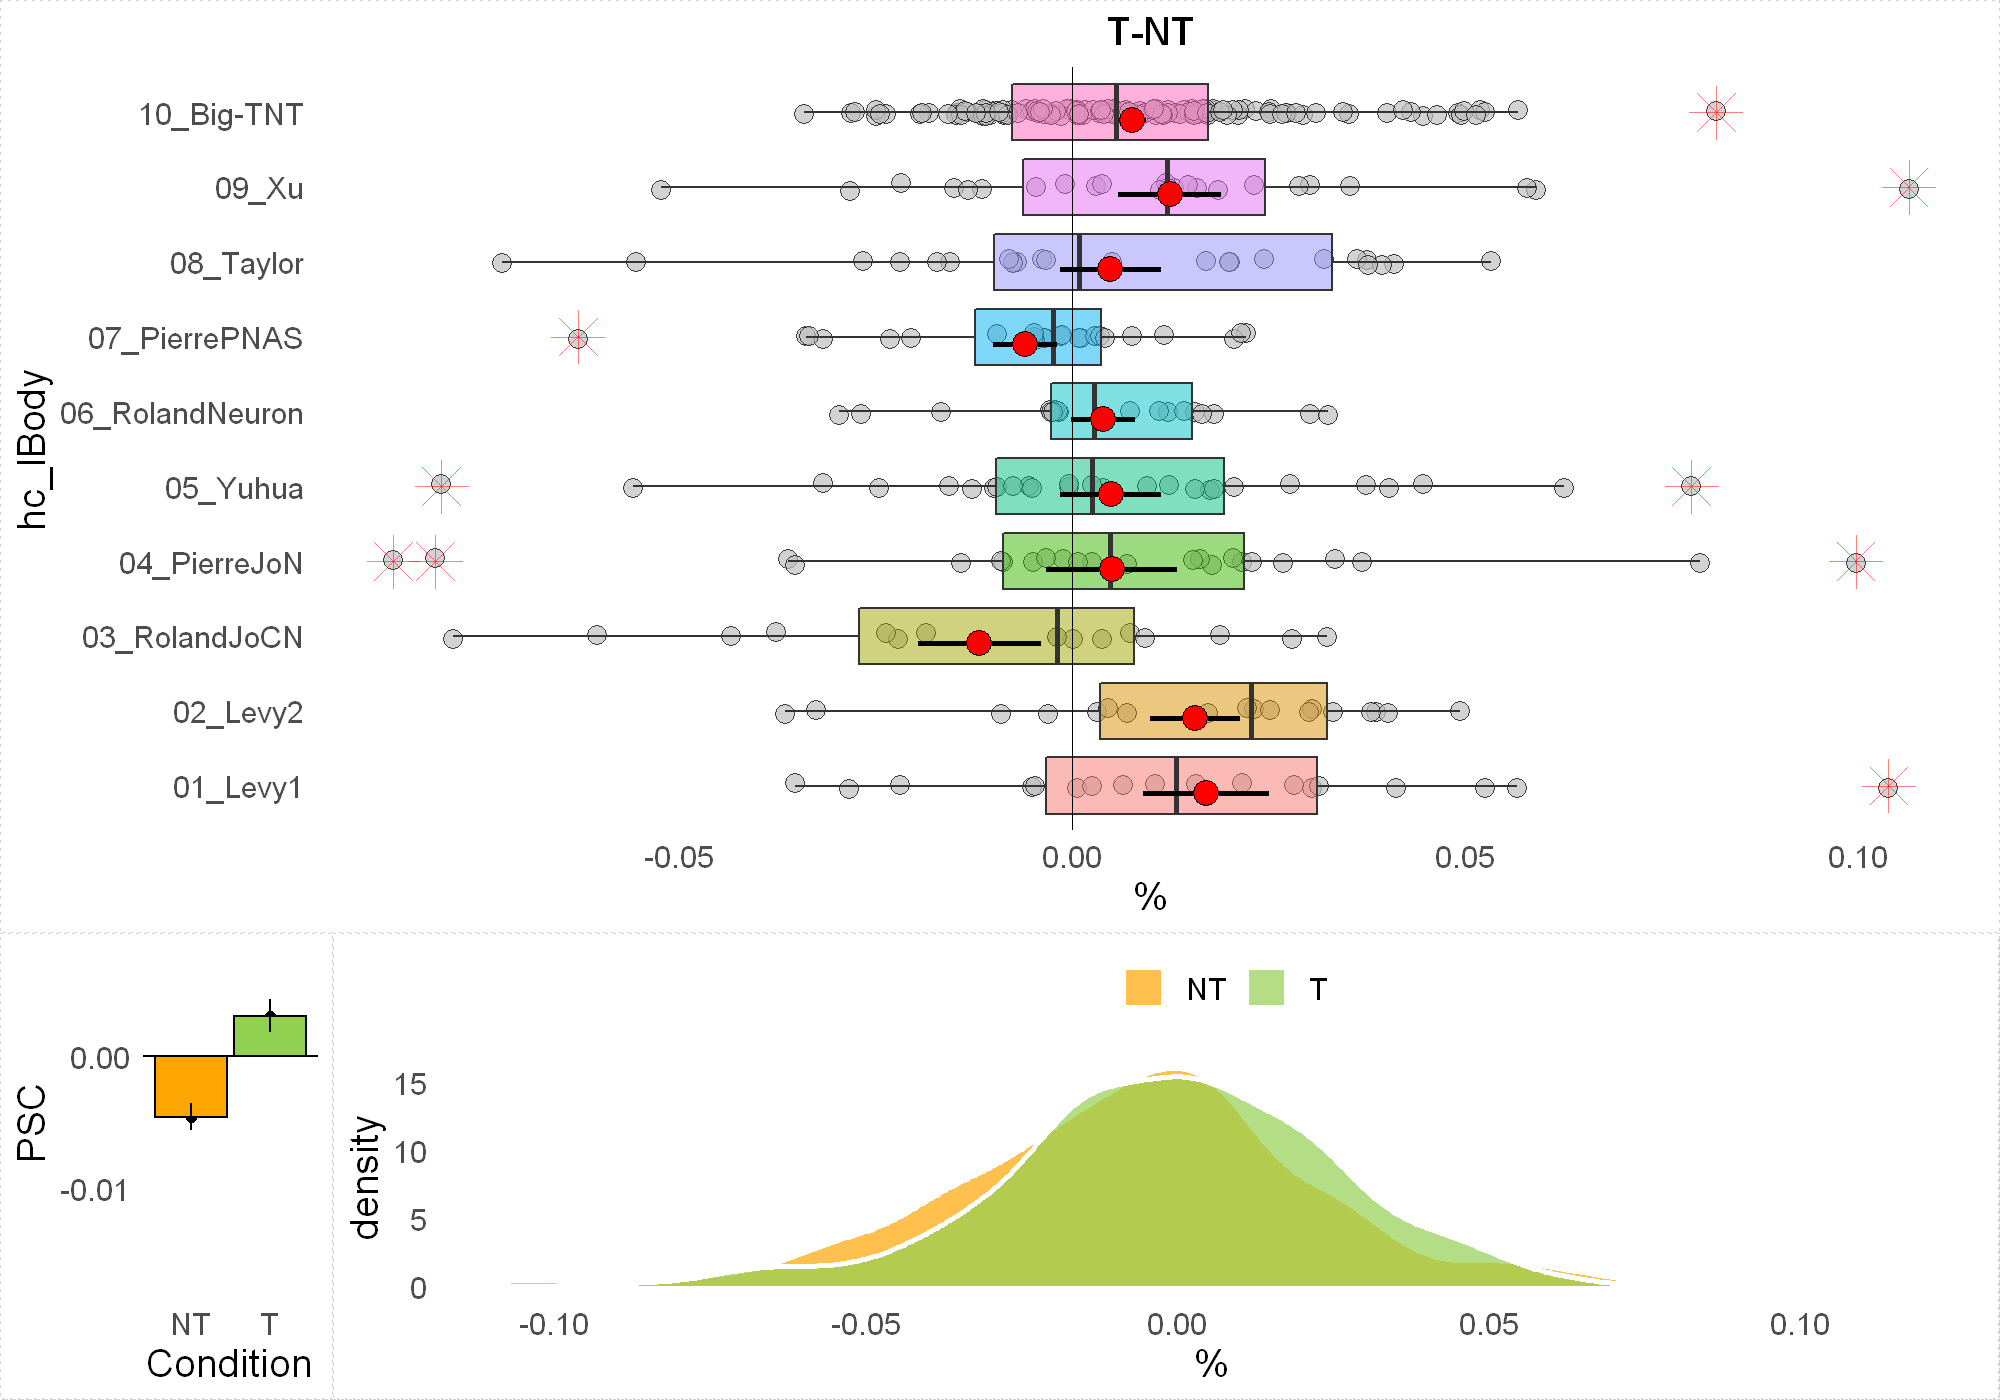

[1] ________________________________________________________________________________
[1]  
[1] ROI:  hc_lTail
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd     F     p p<.05      ges
1           stid   9 320 2.145 0.026     * 0.047000
2      condition   1 320 0.384 0.536       0.000225
3 stid:condition   9 320 1.817 0.064       0.010000
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd     F     p `p<.05`      ges
 * <chr>           <chr>     <dbl> <dbl> <dbl> <dbl> <chr>      <dbl>
 1 01_Levy1        condition     1    17 2.10  0.166 ""      0.036   
 2 02_Levy2        condition     1    1

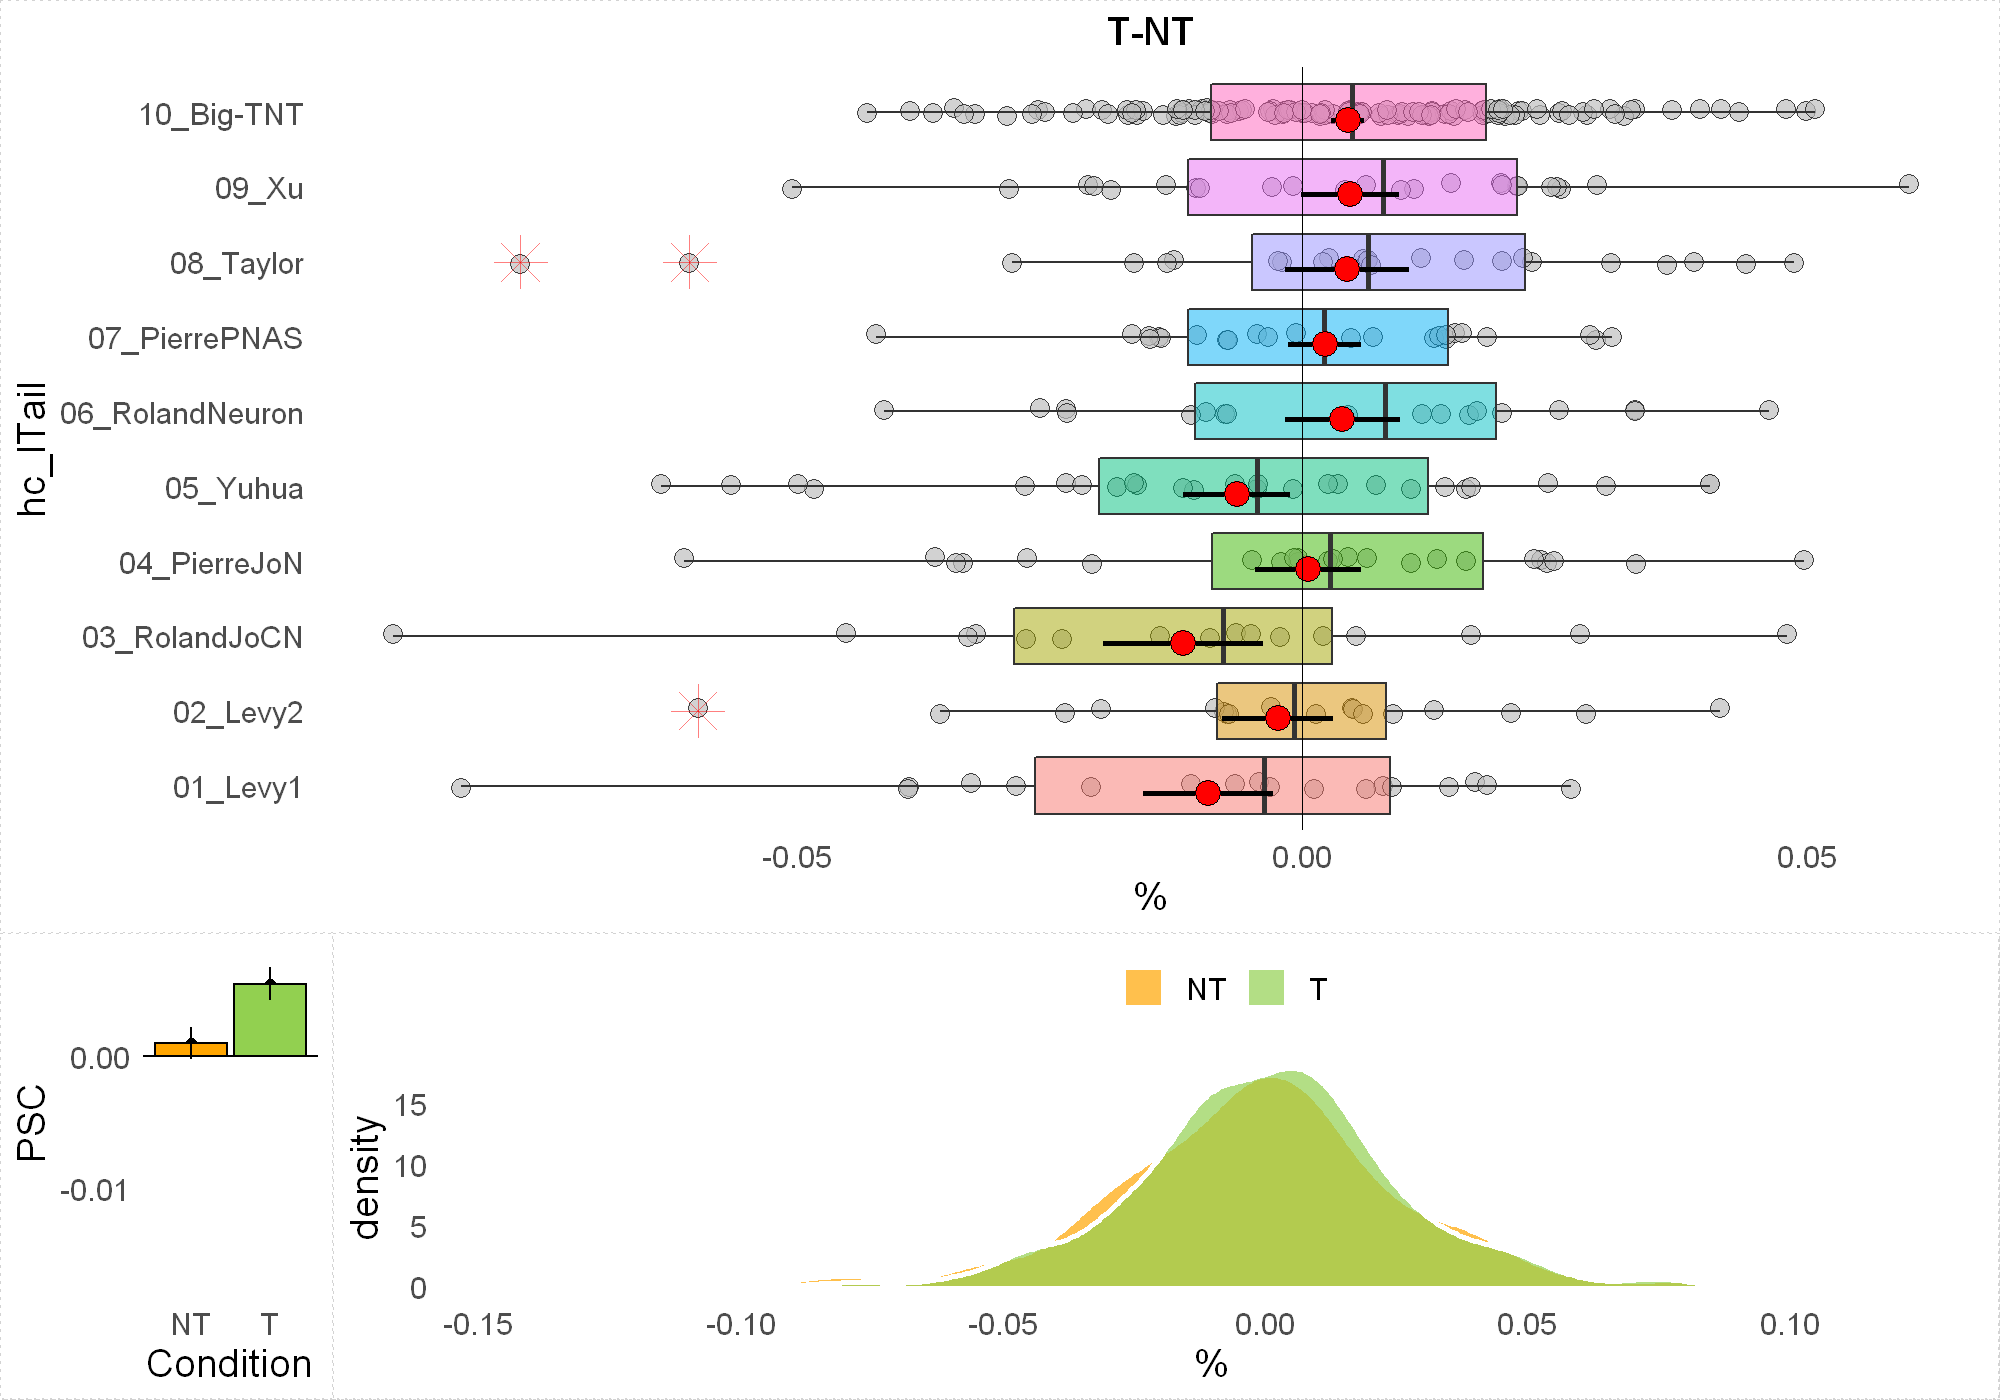

In [24]:
perROIperDSmeans(dataTNT, 7:9)

[1] ________________________________________________________________________________
[1]  
[1] ROI:  rDLPFC
[1] ________________________________________________________________________________
[1]  
[1] ================================================
[1] Mixed ANOVA (Condition x Dataset)
[1] ================================================
ANOVA Table (type III tests)

          Effect DFn DFd       F        p p<.05   ges
1           stid   9 320   6.855 5.00e-09     * 0.129
2      condition   1 320 248.613 7.59e-42     * 0.151
3 stid:condition   9 320   6.805 5.92e-09     * 0.042
[1]  
[1] ================================================
[1] Simple main effects of Condition
[1] ================================================
# A tibble: 10 x 8
   stid            Effect      DFn   DFd     F            p `p<.05`   ges
 * <chr>           <chr>     <dbl> <dbl> <dbl>        <dbl> <chr>   <dbl>
 1 01_Levy1        condition     1    17  38.7 0.00000937   *       0.3  
 2 02_Levy2        co

Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing missing values (geom_bar)."


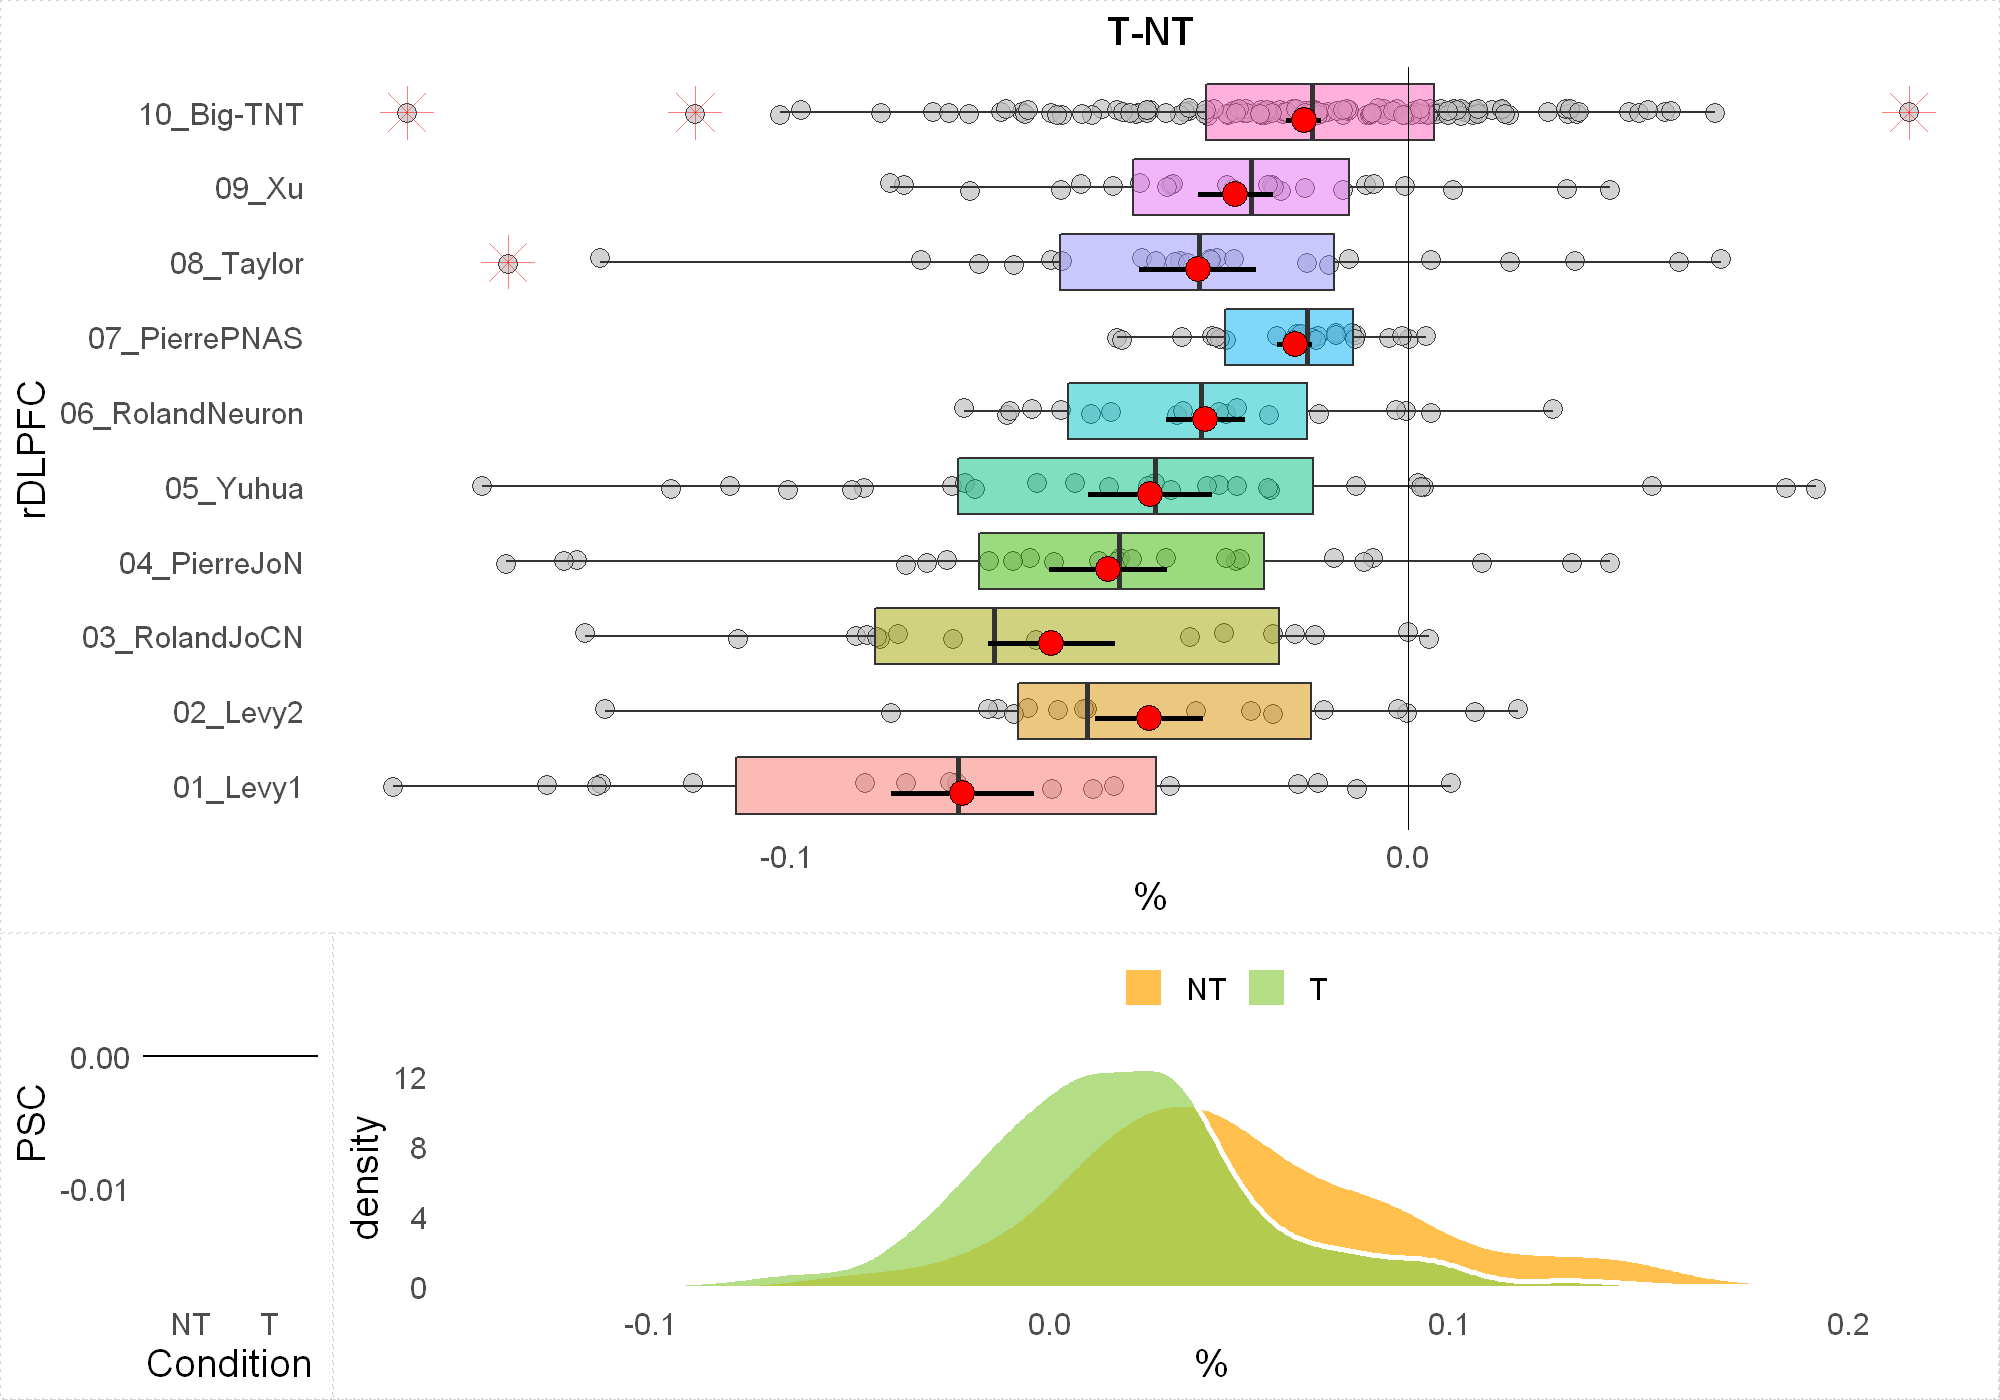

In [25]:
perROIperDSmeans(dataTNT, 10)